# Airbnb - A tale of 2 cities
## A data exploration on the airbnb panorama of Porto and Lisbon

## Background and Aim

Porto and Lisbon are two of the EUropean cities that have shown the biggest touristic growth.
On top of the touristic growth it has seen an incredible growth an proliferation of the tech scene, highlighted by many companies achieving unicorn status and being rated as some of the best work satisfaction.

The goal is to understand how Airbnb has grown in these cities since its establishment and how listings distributions are framed in the city scenary.

## Loading Libraries and Data

Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from re import sub
from decimal import Decimal
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize, WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer, StandardScaler
from math import sqrt
import tests as t
import re
import nltk
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb
pd.set_option('display.max_columns', 106)
sns.set(font_scale=1.5) 

import collections

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sousa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sousa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sousa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data loading

All the data loaded in this cell was sourced from here: http://insideairbnb.com/get-the-data.html

In [2]:
#Porto related data
porto_listings_plus = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\listings.csv.gz", compression = 'gzip')
porto_calendar = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\calendar.csv.gz", compression = 'gzip')
porto_reviews = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\reviews.csv")

#Lisbon related data
lisbon_calendar = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\calendar.csv.gz", compression = 'gzip')
lisbon_reviews = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\reviews.csv")
lisbon_listings_plus = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\listings.csv.gz", compression = 'gzip')


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Checking the shapes of the most important dataframes

In [3]:
porto_listings_plus.shape

(11656, 106)

In [4]:
lisbon_listings_plus.shape

(25056, 106)

#### Lisbon has close to double the number of listings when compared to Porto

Looks like there is no point of keeping 'is_business_travel_ready' they all have the same value: f

In [5]:
porto_listings_plus['is_business_travel_ready'].value_counts()

f    11656
Name: is_business_travel_ready, dtype: int64

In [6]:
lisbon_listings_plus['is_business_travel_ready'].value_counts()

f    25056
Name: is_business_travel_ready, dtype: int64

Checking if there is data diversity in instant_bookable

In [7]:
porto_listings_plus['instant_bookable'].value_counts()

t    9315
f    2341
Name: instant_bookable, dtype: int64

Checking the super host feature

In [8]:
porto_listings_plus['host_is_superhost'].value_counts()

f    7770
t    3851
Name: host_is_superhost, dtype: int64

In [9]:
lisbon_listings_plus['host_is_superhost'].value_counts()

f    18307
t     6723
Name: host_is_superhost, dtype: int64

There is enough data diversity to keep it

In [10]:
lisbon_listings_plus.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6499,https://www.airbnb.com/rooms/6499,20191128004842,2019-11-28,Belém 1 Bedroom Historical Apartment,"This apartment is all about Location, next to ...",Fully furnished apartment (35m2). Small inside...,"This apartment is all about Location, next to ...",none,"To get to the city center, tram 15 stops in f...",Late check in's (after 20H) have an extra char...,The apartment is on the same street as the #15...,The entire apartment is at your disposal.,We'll check you in personally,Respect the neighbours.,NaN,NaN,https://a0.muscache.com/im/pictures/6422ee92-c...,NaN,14455,https://www.airbnb.com/users/show/14455,Bruno,2009-04-22,"Brussels, Bruxelles, Belgium","I am Bruno Luis, a Portuguese living in The Ha...",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/14455/profile...,https://a0.muscache.com/im/users/14455/profile...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Lisbon, Lisbon, Portugal",Belém,Belm,Lisboa,Lisbon,Lisbon,1300,Lisbon,"Lisbon, Portugal",PT,Portugal,38.69675,-9.19840,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""First ai...",377.0,$36.00,$209.00,$579.00,$100.00,$35.00,2,$15.00,3,365,3,3,365,365,3.0,365.0,yesterday,t,0,0,0,0,2019-11-28,25,16,2014-09-02,2019-11-05,90.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,"{Lisbon,"" PT Zipcodes"","" Lisbon"","" PT""}",t,f,moderate,f,f,1,1,0,0,0.39
1,25659,https://www.airbnb.com/rooms/25659,20191128004842,2019-11-28,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",Sunny 1 Bedroom cozy apartment in historic Alf...,"Charming, sunny, cozy apartment in the heart o...",Sunny 1 Bedroom cozy apartment in historic Alf...,none,Alfama is the oldest and most picturesque quar...,CHECK-IN 15h -24h ( 3pm - midnight) CHECK-O...,The apartment is very convenient to all kinds ...,CHECK-IN 15h -00h ( 3pm - midnight) CHECK-O...,I am available by email ( or in person if I am...,No smoking. No pets. Only booked guests are e...,NaN,NaN,https://a0.muscache.com/im/pictures/a4c86b5f-c...,NaN,107347,https://www.airbnb.com/users/show/107347,Ellie,2010-04-12,"New York, New York, United States",Artist,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/7c768...,https://a0.muscache.com/im/pictures/user/7c768...,Alfama,1.0,1.0,"['email', 'phone

In [11]:
porto_listings_plus.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,41339,https://www.airbnb.com/rooms/41339,20191128004830,2019-11-28,Porto city flat near the sea,Here you'll find all you need for your holiday...,"Apartment facing Southeast, with a big bedroom...",Here you'll find all you need for your holiday...,none,In the surrounds you have Serralves Museum and...,--City Touristic Tax: Your stay includes 2€ pe...,There's a lot of public transports that takes ...,You have total access to the apartment.,CHECK-IN From 14:00 to 22:00 Depending on your...,"* The price includes electricity, water, wi-fi...",NaN,NaN,https://a0.muscache.com/im/pictures/25727334/9...,NaN,180050,https://www.airbnb.com/users/show/180050,Paula,2010-07-25,"Oporto, Porto District, Portugal","Olá, sou a Paula e adoro a minha cidade!\r\nAd...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/b2ec5...,https://a0.muscache.com/im/pictures/user/b2ec5...,NaN,19.0,19.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Porto, Porto, Portugal",NaN,Lordelo do Ouro e Massarelos,PORTO,Porto,Porto,4150,Porto,"Porto, Portugal",PT,Portugal,41.14894,-8.66113,f,Apartment,Entire home/apt,5,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",NaN,$58.00,NaN,NaN,$100.00,$30.00,2,$8.00,2,90,2,2,90,90,2.0,90.0,2 months ago,t,0,0,0,210,2019-11-28,17,0,2013-05-15,2018-09-28,93.0,9.0,10.0,10.0,10.0,9.0,9.0,t,29049/AL,"{Porto,"" PT Zip Codes"","" Porto"","" PT""}",t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.21
1,42462,https://www.airbnb.com/rooms/42462,20191128004830,2019-11-28,Large Penthouse in Vila Nova Gaia,The Afurada Harbour can be reached within 10 m...,It's the perfect choice for family holidays or...,The Afurada Harbour can be reached within 10 m...,none,NaN,Por favor contactem-me sempre que for necessário.,NaN,Os hóspedes podem estacionar as viaturas nas z...,Durante a sua estadia eu estarei sempre contac...,This apartment is not suitable for parties aft...,NaN,NaN,https://a0.muscache.com/im/pictures/12513715/7...,NaN,185492,https://www.airbnb.com/users/show/185492,Gabriela,2010-07-30,"Vila Nova de Gaia, Porto District, Portugal","Hi everyone, my name is Gabriela. I was born i...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/ebe25...,https://a0.muscache.com/im/p

### Cleanup and EDA

Checking missing values

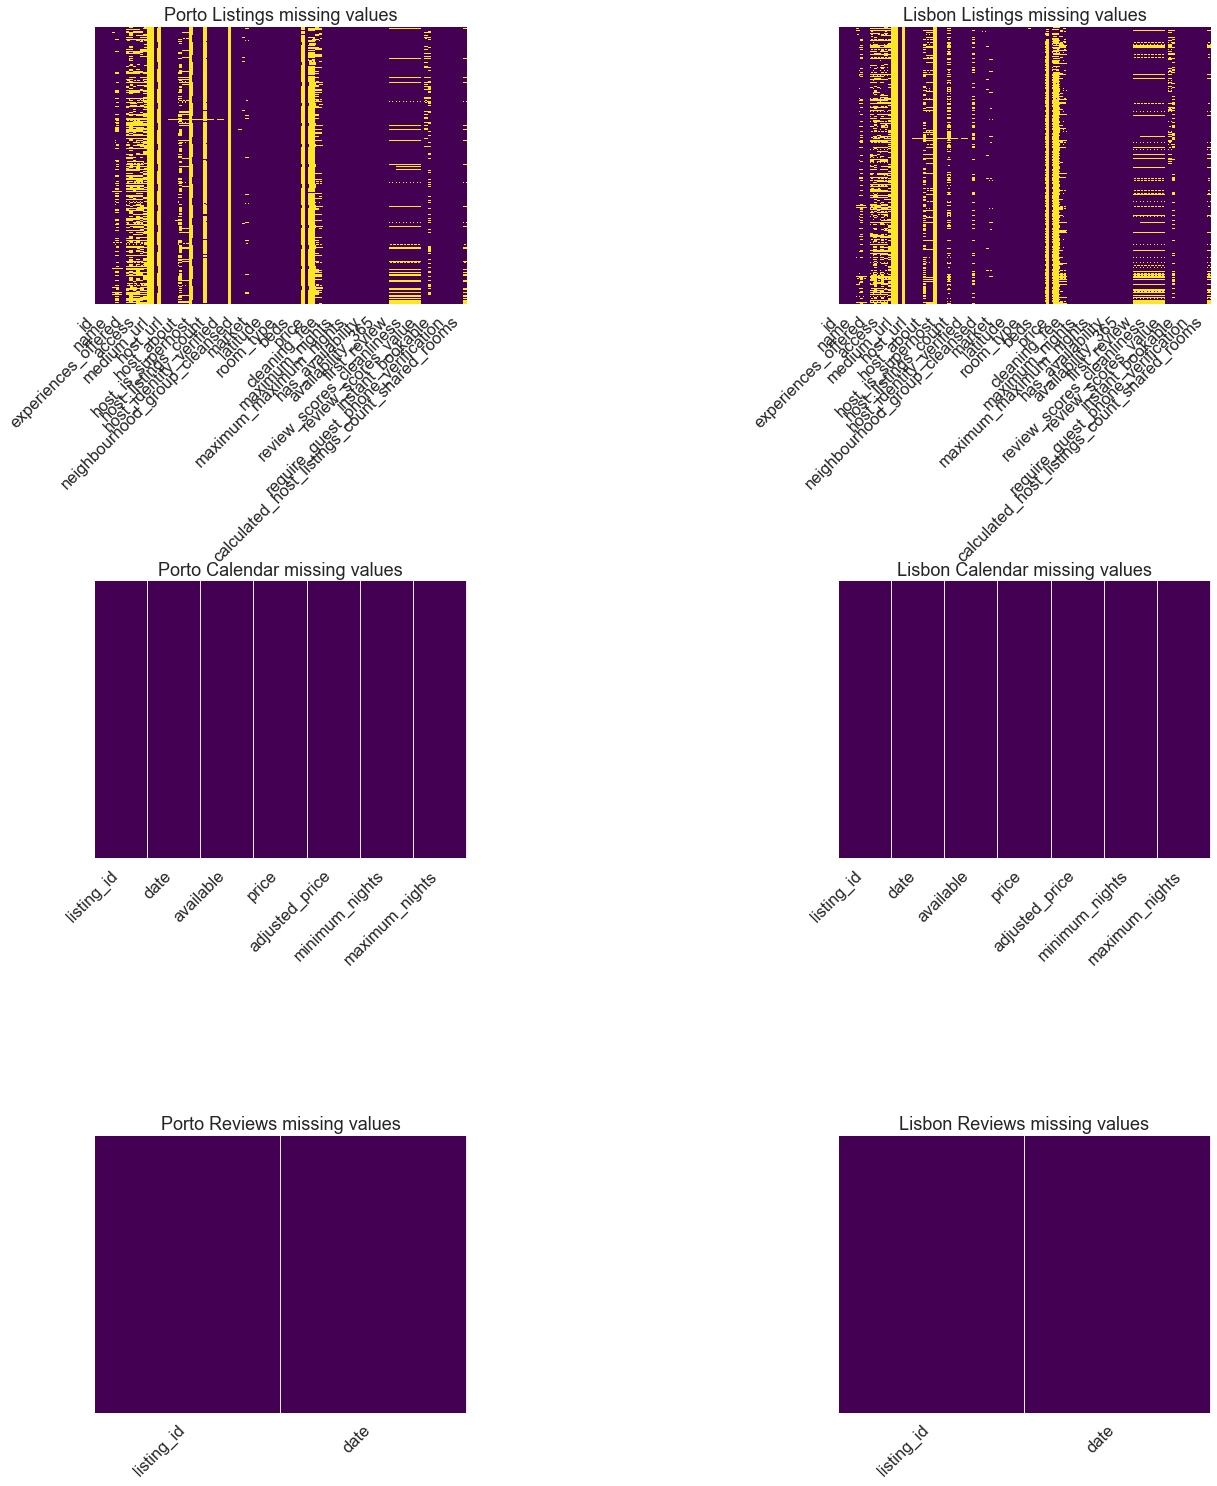

In [12]:
#pyplot is matplotlibs graphing framework, let's use it to make some subplots
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)


sns.heatmap(porto_listings_plus.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax1)
ax1.set_title('Porto Listings missing values')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(lisbon_listings_plus.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax2)
ax2.set_title('Lisbon Listings missing values')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(porto_calendar.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax3)
ax3.set_title('Porto Calendar missing values')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(lisbon_calendar.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax4)
ax4.set_title('Lisbon Calendar missing values')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(porto_reviews.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax5)
ax5.set_title('Porto Reviews missing values')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation = 45, horizontalalignment='right')

sns.heatmap(lisbon_reviews.isnull(), yticklabels = False, cbar = False, cmap='viridis', ax = ax6)
ax6.set_title('Lisbon Reviews missing values')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation = 45, horizontalalignment='right')


fig.subplots_adjust(top = 1.5, wspace = 1, hspace = 1)

Since I will be comparing Porto to Lisbon one of the first things to check is if they have exactly the same columns on their dataframes.

In [13]:
def column_checker(porto_df, lisbon_df):
    '''
    Takes in 2 dataframes and checks if attributes match between the 2 dataframes 
    Args: any 2 dataframes 
    prints True or False if the dataframes match or not and which values are different
    '''
    porto_column_list = porto_df.columns.values
    lisbon_column_list = lisbon_df.columns.values
    
    equal = collections.Counter(porto_column_list) == collections.Counter(lisbon_column_list)
    
    print('The two tested dataframes are balanced: ', equal)
    
    if equal == False:
        print('The Porto df differs from Lisbon on the following columns: ')
        print(set(porto_column_list) - set(lisbon_column_list))
        
        print('The Lisbon df differs from the Porto df on the following colums: ')
        print(set(lisbon_column_list) - set(porto_column_list))

In [14]:
#checking column balance between listings
column_checker(porto_listings_plus, lisbon_listings_plus)

The two tested dataframes are balanced:  True


In [15]:
#checking column balance between calendar
column_checker(porto_calendar, lisbon_calendar)

The two tested dataframes are balanced:  True


In [16]:
#checking column balance between reviews
column_checker(porto_reviews, lisbon_reviews)

The two tested dataframes are balanced:  True


In [17]:
#checking the shape of the dfs:
print(porto_listings_plus.shape)
print(lisbon_listings_plus.shape)
print(porto_calendar.shape)
print(lisbon_calendar.shape)
print(porto_reviews.shape)
print(lisbon_reviews.shape)


(11656, 106)
(25056, 106)
(4254440, 7)
(9145440, 7)
(501193, 2)
(1033354, 2)


The neighbourhoods dfs have information that is repeated in the listings df. So I will drop their usage from here on.

All the dataframes have the same columns which is great, no information needs to be dropped

Checking column data types

In [18]:
porto_listings_plus.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

In [19]:
porto_calendar.dtypes

listing_id         int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     int64
maximum_nights     int64
dtype: object

In [20]:
porto_reviews.dtypes

listing_id     int64
date          object
dtype: object

To reduce the data in usage and make EDA easier I will start by dropping columns that are on no interest, namely regarding hyperlinks, images and repeated information

In [21]:
#checking if these 2 colunms are the same so I can drop one of them, I suspect they are dup info
porto_listings_plus['host_listings_count'].equals(porto_listings_plus['host_total_listings_count'])

True

In [22]:
porto_listings_plus.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,41339,https://www.airbnb.com/rooms/41339,20191128004830,2019-11-28,Porto city flat near the sea,Here you'll find all you need for your holiday...,"Apartment facing Southeast, with a big bedroom...",Here you'll find all you need for your holiday...,none,In the surrounds you have Serralves Museum and...,--City Touristic Tax: Your stay includes 2€ pe...,There's a lot of public transports that takes ...,You have total access to the apartment.,CHECK-IN From 14:00 to 22:00 Depending on your...,"* The price includes electricity, water, wi-fi...",NaN,NaN,https://a0.muscache.com/im/pictures/25727334/9...,NaN,180050,https://www.airbnb.com/users/show/180050,Paula,2010-07-25,"Oporto, Porto District, Portugal","Olá, sou a Paula e adoro a minha cidade!\r\nAd...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/b2ec5...,https://a0.muscache.com/im/pictures/user/b2ec5...,NaN,19.0,19.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Porto, Porto, Portugal",NaN,Lordelo do Ouro e Massarelos,PORTO,Porto,Porto,4150,Porto,"Porto, Portugal",PT,Portugal,41.14894,-8.66113,f,Apartment,Entire home/apt,5,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",NaN,$58.00,NaN,NaN,$100.00,$30.00,2,$8.00,2,90,2,2,90,90,2.0,90.0,2 months ago,t,0,0,0,210,2019-11-28,17,0,2013-05-15,2018-09-28,93.0,9.0,10.0,10.0,10.0,9.0,9.0,t,29049/AL,"{Porto,"" PT Zip Codes"","" Porto"","" PT""}",t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.21
1,42462,https://www.airbnb.com/rooms/42462,20191128004830,2019-11-28,Large Penthouse in Vila Nova Gaia,The Afurada Harbour can be reached within 10 m...,It's the perfect choice for family holidays or...,The Afurada Harbour can be reached within 10 m...,none,NaN,Por favor contactem-me sempre que for necessário.,NaN,Os hóspedes podem estacionar as viaturas nas z...,Durante a sua estadia eu estarei sempre contac...,This apartment is not suitable for parties aft...,NaN,NaN,https://a0.muscache.com/im/pictures/12513715/7...,NaN,185492,https://www.airbnb.com/users/show/185492,Gabriela,2010-07-30,"Vila Nova de Gaia, Porto District, Portugal","Hi everyone, my name is Gabriela. I was born i...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/ebe25...,https://a0.muscache.com/im/p

In [23]:
def column_dropper(df):
    '''
    Takes in a dataframe and drops columns that will be of no used to this particular flavor of EDA
    Args: dataframe we want to reduce
    Returns: reduced dataframe
    '''
    #dropping the columns I am not interested in
    #of note host_acceptance_rate is all NaNs, square_feet is missing 99% of the data, weekly and monthly price are missing
    #over 90% of the data
    
    df = df.drop(['listing_url', 'scrape_id', 'last_scraped', 
                  'name', 'summary', 'description', 
                  'experiences_offered', 'neighborhood_overview', 'notes', 
                  'access', 'interaction', 'house_rules', 
                  'thumbnail_url', 'medium_url', 'picture_url', 
                  'xl_picture_url', 'host_url', 'host_about', 
                  'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                  'host_total_listings_count', 'host_verifications', 'street', 
                  'neighbourhood', 'city', 'market', 
                  'smart_location', 'country_code', 'minimum_minimum_nights', 
                  'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
                  'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 
                  'availability_30', 'availability_60', 'availability_90', 
                  'calendar_last_scraped', 'license', 'jurisdiction_names', 
                  'country', 'state', 'zipcode', 
                  'host_acceptance_rate', 'square_feet', 'requires_license', 
                  'bed_type', 'weekly_price', 'monthly_price', 
                  'maximum_nights', 'number_of_reviews_ltm', 'calculated_host_listings_count_entire_homes', 
                  'calculated_host_listings_count_private_rooms', 'guests_included', 'is_business_travel_ready',
                  'calculated_host_listings_count_shared_rooms', 'calculated_host_listings_count'], 
                 axis = 1, inplace = True)
    
    return df
    

In [24]:
column_dropper(porto_listings_plus)
column_dropper(lisbon_listings_plus)

In [25]:
porto_listings_plus.head()

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,41339,"Apartment facing Southeast, with a big bedroom...",There's a lot of public transports that takes ...,180050,Paula,2010-07-25,"Oporto, Porto District, Portugal",within an hour,100%,f,19.0,t,t,Lordelo do Ouro e Massarelos,PORTO,41.14894,-8.66113,f,Apartment,Entire home/apt,5,1.0,1.0,4.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",$58.00,$100.00,$30.00,$8.00,2,t,210,17,2013-05-15,2018-09-28,93.0,9.0,10.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,f,f,0.21
1,42462,It's the perfect choice for family holidays or...,NaN,185492,Gabriela,2010-07-30,"Vila Nova de Gaia, Porto District, Portugal",within an hour,100%,t,3.0,t,t,Mafamude e Vilar do Paraíso,VILA NOVA DE GAIA,41.10739,-8.59430,t,Apartment,Entire home/apt,9,3.0,3.0,8.0,"{TV,""Cable TV"",Wifi,Kitchen,""Free parking on p...",$50.00,$0.00,$25.00,$8.00,4,t,31,39,2012-12-31,2018-10-14,95.0,10.0,10.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,f,f,0.46
2,55111,The first floor in house with shared pool. It...,NaN,259711,Isabel E João,2010-10-12,"Porto, Porto, Portugal",NaN,NaN,t,3.0,t,t,Cete,PAREDES,41.17481,-8.35362,t,Apartment,Entire home/apt,5,1.0,2.0,5.0,"{TV,Wifi,Pool,Kitchen,""Free parking on premise...",$66.00,$150.00,$0.00,$0.00,4,t,0,14,2015-07-18,2019-09-07,96.0,10.0,9.0,10.0,10.0,10.0,10.0,f,moderate,f,f,0.26
3,70925,Apartment with the best view of the Porto city...,The house is 1 minute walking from the metro s...,361205,Miguel,2011-01-25,"Vila Nova de Gaia, Porto District, Portugal",within an hour,100%,t,2.0,t,t,Santa Marinha e São Pedro da Afurada,VILA NOVA DE GAIA,41.13810,-8.61108,t,Apartment,Entire home/apt,6,1.0,2.0,2.0,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",$97.00,$94.00,$0.00,$5.00,4,t,349,56,2011-09-05,2019-10-17,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,0.56
4,73828,The first floor in house with shared pool. Ou...,NaN,259711,Isabel E João,2010-10-12,"Porto, Porto, Portugal",NaN,NaN,t,3.0,t,t,Cete,PAREDES,41.17449,-8.35426,t,Apartment,Entire home/apt,5,1.0,2.0,5.0,"{TV,Wifi,Pool,Kitchen,""Free parking on premise...",$66.00,$150.00,NaN,$0.00,4,t,0,8,2015-05-09,2019-07-22,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,moderate,f,f,0.14


In [26]:
lisbon_listings_plus.head()

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,6499,Fully furnished apartment (35m2). Small inside...,The apartment is on the same street as the #15...,14455,Bruno,2009-04-22,"Brussels, Bruxelles, Belgium",within an hour,100%,f,1.0,t,f,Belm,Lisboa,38.69675,-9.19840,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""First ai...",$36.00,$100.00,$35.00,$15.00,3,t,0,25,2014-09-02,2019-11-05,90.0,9.0,9.0,10.0,10.0,10.0,9.0,t,moderate,f,f,0.39
1,25659,"Charming, sunny, cozy apartment in the heart o...",The apartment is very convenient to all kinds ...,107347,Ellie,2010-04-12,"New York, New York, United States",within an hour,100%,t,1.0,t,t,Santa Maria Maior,Lisboa,38.71167,-9.12696,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$60.00,$150.00,$30.00,$0.00,3,t,331,112,2014-04-24,2019-11-08,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,1.64
2,28066,traditional farm house in a quiet place where ...,NaN,120855,Lucia,2010-05-08,"Aveiras de Cima, Lisboa, Portugal",NaN,NaN,f,1.0,t,f,Aveiras de Cima,Azambuja,39.14654,-8.91503,f,House,Private room,2,NaN,1.0,NaN,{},$53.00,NaN,NaN,$0.00,1,t,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
3,29138,"05 minutes from city center by subway, 10 minu...",NaN,125304,Susana,2010-05-15,"Lisbon, Lisbon, Portugal",NaN,NaN,f,1.0,t,f,Areeiro,Lisboa,38.73634,-9.13792,f,Apartment,Private room,1,NaN,1.0,NaN,{},$71.00,NaN,NaN,$0.00,1,t,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
4,29248,"Located in the city center, and great location...",NaN,125768,Bárbara,2010-05-16,"Lisbon, Lisbon, Portugal",within a few hours,90%,f,3.0,t,f,Santa Maria Maior,Lisboa,38.71272,-9.12628,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",$60.00,$0.00,$40.00,$10.00,3,t,365,319,2011-01-01,2019-10-29,91.0,10.0,9.0,10.0,10.0,10.0,9.0,t,moderate,f,f,2.94


There are some columns with date and time data that need to be converted to floats and datetime formats, but it also seems like there is no difference between price and adjusted price in the calendar dataframe

In [27]:
#checking if there is a difference between price and adjusted_price
porto_calendar['price'].equals(porto_calendar['adjusted_price'])

False

In [28]:
lisbon_calendar['price'].equals(lisbon_calendar['adjusted_price'])

False

There seems to be a difference between them so I will keep both

In [29]:
def dtype_fixer(df, df_type):
    '''
    Takes in a dataframe and changes the datatypes of the specified columns 
    Args: a dataframe and the type of data it corresponds to
    Returns: dataframe with intended datatypes on the specified columns
    '''
    
    if df_type == 'calendar':
        
        #getting rid of the dollar sign 
        df['price'] = df['price'].str.replace('$', '')
        df['adjusted_price'] = df['adjusted_price'].str.replace('$', '')
      

        #cast object to float
        df['price'] = pd.to_numeric(df['price'],errors='coerce')
        df['adjusted_price'] = pd.to_numeric(df['adjusted_price'],errors='coerce')


        #convert datetime to date
        df['date'] = pd.to_datetime(df['date'])
        
    if df_type == 'listings':
        #getting rid of % sign
        df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
        df['host_response_rate'] = pd.to_numeric(df['host_response_rate'],errors='coerce')
        
        #getting rid of $ sign
        df['price'] = df['price'].str.replace('$', '')
        df['price'] = pd.to_numeric(df['price'],errors='coerce')
        
        df['security_deposit'] = df['security_deposit'].str.replace('$', '')
        df['security_deposit'] = pd.to_numeric(df['security_deposit'],errors='coerce')

        
        df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '')
        df['cleaning_fee'] = pd.to_numeric(df['cleaning_fee'],errors='coerce')
        
        df['extra_people'] = df['extra_people'].str.replace('$', '')
        df['extra_people'] = pd.to_numeric(df['extra_people'],errors='coerce')
        
        
        #fixing dates
        df['host_since'] = pd.to_datetime(df['host_since'])
        df['first_review'] = pd.to_datetime(df['first_review'])
        df['last_review'] = pd.to_datetime(df['last_review'])
        
    
    return df

In [30]:
dtype_fixer(porto_calendar, 'calendar')
dtype_fixer(lisbon_calendar, 'calendar')
dtype_fixer(porto_listings_plus, 'listings')
dtype_fixer(lisbon_listings_plus, 'listings')

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,6499,Fully furnished apartment (35m2). Small inside...,The apartment is on the same street as the #15...,14455,Bruno,2009-04-22,"Brussels, Bruxelles, Belgium",within an hour,100.0,f,1.0,t,f,Belm,Lisboa,38.69675,-9.19840,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""First ai...",36.0,100.0,35.0,15.0,3,t,0,25,2014-09-02,2019-11-05,90.0,9.0,9.0,10.0,10.0,10.0,9.0,t,moderate,f,f,0.39
1,25659,"Charming, sunny, cozy apartment in the heart o...",The apartment is very convenient to all kinds ...,107347,Ellie,2010-04-12,"New York, New York, United States",within an hour,100.0,t,1.0,t,t,Santa Maria Maior,Lisboa,38.71167,-9.12696,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",60.0,150.0,30.0,0.0,3,t,331,112,2014-04-24,2019-11-08,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,1.64
2,28066,traditional farm house in a quiet place where ...,NaN,120855,Lucia,2010-05-08,"Aveiras de Cima, Lisboa, Portugal",NaN,NaN,f,1.0,t,f,Aveiras de Cima,Azambuja,39.14654,-8.91503,f,House,Private room,2,NaN,1.0,NaN,{},53.0,NaN,NaN,0.0,1,t,365,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
3,29138,"05 minutes from city center by subway, 10 minu...",NaN,125304,Susana,2010-05-15,"Lisbon, Lisbon, Portugal",NaN,NaN,f,1.0,t,f,Areeiro,Lisboa,38.73634,-9.13792,f,Apartment,Private room,1,NaN,1.0,NaN,{},71.0,NaN,NaN,0.0,1,t,365,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
4,29248,"Located in the city center, and great location...",NaN,125768,Bárbara,2010-05-16,"Lisbon, Lisbon, Portugal",within a few hours,90.0,f,3.0,t,f,Santa Maria Maior,Lisboa,38.71272,-9.12628,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,"{TV,Internet,Wifi,Kitchen,""Paid parking off pr...",60.0,0.0,40.0,10.0,3,t,365,319,2011-01-01,2019-10-29,91.0,10.0,9.0,10.0,10.0,10.0,9.0,t,moderate,f,f,2.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25051,40420286,Would you like to feel the pleasure of royalty...,NaN,4972896,Rita Morais,2013-02-05,"Cascais, Lisbon District, Portugal",within an hour,100.0,f,39.0,t,t,Cascais e Estoril,Cascais,38.70160,-9.38394,t,Serviced apartment,Entire home/apt,4,2.0,2.0,3.0,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",75.0,200.0,45.0,15.0,1,t,353,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,super_strict_30,f,f,NaN
25052,40420363,Looking for the perfect place for your family ...,NaN,4972896,Rita Morais,2013-02-05,"Cascais, Lisbon District, Portugal",within an hour,100.0,f,39.0,t,t,Cascais e Estoril,Cascais,38.70160,-9.38394,t,Serviced apartment,Entire home/apt,6,1.0,3.0,4.0,"{""Cable TV"",Wifi,""Air conditioning"",Kitchen,""F...",79.0,200.0,45.0,23.0,1,t,353,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,super_strict_30,f,f,NaN
25053,40420871,"Here, you'll have Lisbon at your feet. In this...","From Lisbon Airport, catch the metro to São Se...",1969293,Tiago,2012-03-19,"Lisbon, Lisbon, Portugal",within an hour,100.0,f,45.0,t,t,Arroios,Lisboa,38.72640,-9.14130,t,Apartment,Entire home/apt,4,2.0,2.0,3.0,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",165.0,150.0,0.0,0.0,2,

In [31]:
porto_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,41339,2019-11-28,f,55.0,55.0,2,90
1,147502,2019-11-28,t,42.0,42.0,1,730
2,147502,2019-11-29,t,42.0,42.0,1,730
3,147502,2019-11-30,t,42.0,42.0,1,730
4,147502,2019-12-01,t,42.0,42.0,1,730


In [32]:
#checking for missing values
def missing_checker(df, df_type):
    '''
    Takes in a dataframe and determines th number of missing values  
    Args: a dataframe 
    Prints: number of missing values
    '''
    #print('Number of missing values in ' + title + ' is: ')
    #print(df.isnull().sum())
    
    #percentage of missing values
    percent_missing = df.isnull().sum()* 100/len(df)
    #percent_missing_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    print('_______________________' + df_type + '_______________________')
    print(percent_missing)

In [33]:
missing_checker(porto_listings_plus, 'porto_listings')

_______________________porto_listings_______________________
id                                   0.000000
space                               25.900824
transit                             34.497255
host_id                              0.000000
host_name                            0.300275
host_since                           0.300275
host_location                        0.446122
host_response_time                  12.877488
host_response_rate                  12.877488
host_is_superhost                    0.300275
host_listings_count                  0.300275
host_has_profile_pic                 0.300275
host_identity_verified               0.300275
neighbourhood_cleansed               0.000000
neighbourhood_group_cleansed         0.000000
latitude                             0.000000
longitude                            0.000000
is_location_exact                    0.000000
property_type                        0.000000
room_type                            0.000000
accommodates       

In [34]:
missing_checker(lisbon_listings_plus, 'lisbon_listings')

_______________________lisbon_listings_______________________
id                                   0.000000
space                               21.020913
transit                             32.654853
host_id                              0.000000
host_name                            0.103768
host_since                           0.103768
host_location                        0.267401
host_response_time                  14.587324
host_response_rate                  14.587324
host_is_superhost                    0.103768
host_listings_count                  0.103768
host_has_profile_pic                 0.103768
host_identity_verified               0.103768
neighbourhood_cleansed               0.000000
neighbourhood_group_cleansed         0.000000
latitude                             0.000000
longitude                            0.000000
is_location_exact                    0.000000
property_type                        0.000000
room_type                            0.000000
accommodates      

In [35]:
missing_checker(porto_calendar, 'porto_calendar')

_______________________porto_calendar_______________________
listing_id        0.000000
date              0.000000
available         0.000000
price             0.320136
adjusted_price    0.318585
minimum_nights    0.000000
maximum_nights    0.000000
dtype: float64


In [36]:
missing_checker(lisbon_calendar, 'lisbon_calendar')

_______________________lisbon_calendar_______________________
listing_id        0.000000
date              0.000000
available         0.000000
price             0.532834
adjusted_price    0.531478
minimum_nights    0.000000
maximum_nights    0.000000
dtype: float64


In [37]:
missing_checker(porto_reviews, 'porto_reviews')

_______________________porto_reviews_______________________
listing_id    0.0
date          0.0
dtype: float64


In [38]:
missing_checker(lisbon_reviews, 'lisbon_reviews')

_______________________lisbon_reviews_______________________
listing_id    0.0
date          0.0
dtype: float64


There are a few columns related to pricing that have very high numbers of missing values, I am just going to turn them into a boolean column to remark the presence or absence of a values to start with

In [39]:
#to help with the next steps I will extract a list of all the columns that have missing values and need to be dealt with
print('_______________________porto_listings missing list_______________________')
print(porto_listings_plus.columns[porto_listings_plus.isna().any()].tolist())

print('_______________________lisbon_listings missing list_______________________')
print(lisbon_listings_plus.columns[lisbon_listings_plus.isna().any()].tolist())

print('_______________________porto_calendar missing list_______________________')
print(porto_calendar.columns[porto_calendar.isna().any()].tolist())

print('_______________________lisbon_calendar missing list_______________________')
print(lisbon_calendar.columns[lisbon_calendar.isna().any()].tolist())

_______________________porto_listings missing list_______________________
['space', 'transit', 'host_name', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
_______________________lisbon_listings missing list_______________________
['space', 'transit', 'host_name', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating'

In [40]:
def missing_values_handler(df, df_type):
    '''
    Takes in a dataframe and creates a column to keep track of missing values
    Also does imputation on some of the missing values
    Args: a dataframe and the name of the dataframe
    Returns: df without missing values
    '''
    
    if df_type == 'listings':
    
        #creating a column to keep track of rows with missing values using booleans, missing values will be 0
        df['host_name_present'] = (~df['host_name'].isnull()).astype(int)
        df['transit'] = (~df['transit'].isnull()).astype(int)
        df['space'] = (~df['space'].isnull()).astype(int)

        
        #fill NaT with a mock date
        df['last_review_present'] = (~df['last_review'].isnull()).astype(int)
        date_replace = pd.to_datetime('2019-12-31')
        df['last_review'] = df['last_review'].replace({pd.NaT : date_replace})
        
        df['first_review_present'] = (~df['first_review'].isnull()).astype(int)
        date_replace = pd.to_datetime('2019-12-31')
        df['first_review'] = df['first_review'].replace({pd.NaT : date_replace})
        
        df['host_since_present'] = (~df['host_since'].isnull()).astype(int)
        date_replace = pd.to_datetime('2019-12-31')
        df['host_since'] = df['host_since'].replace({pd.NaT : date_replace})
        
                
        #fill the NaNs in remaining columns using sklearn's imputer
        imp = Imputer(missing_values =  np.nan, strategy = 'mean', axis = 0)
        
        #df['reviews_p_month_present'] = (~df['reviews_per_month'].isnull()).astype(int)
        
        df['security_deposit'] = (~df['security_deposit'].isnull()).astype(int)
        
        df['cleaning_fee'] = (~df['cleaning_fee'].isnull()).astype(int)
        
        #df['reviews_per_month'] = imp.fit_transform(df[['reviews_per_month']]).ravel()
          
        #df['host_response_rate'] = imp.fit_transform(df[['host_response_rate']]).ravel()
        
        #and for anything else missing I will just drop it
        df.dropna(inplace = True)
            
    if df_type == 'calendar':
        #the shape of the df demonstrates that it is a 7 figure number of rows show I will just drop
        # the under 200 data points missing
        df.dropna(inplace = True)
        
  
    return df

In [41]:
porto_listings_m = missing_values_handler(porto_listings_plus, 'listings')
lisbon_listings_m = missing_values_handler(lisbon_listings_plus, 'listings')
porto_calendar_m = missing_values_handler(porto_calendar, 'calendar')
lisbon_calendar_m = missing_values_handler(lisbon_calendar, 'calendar')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
missing_checker(porto_listings_plus, 'porto_listings')

_______________________porto_listings_______________________
id                                  0.0
space                               0.0
transit                             0.0
host_id                             0.0
host_name                           0.0
host_since                          0.0
host_location                       0.0
host_response_time                  0.0
host_response_rate                  0.0
host_is_superhost                   0.0
host_listings_count                 0.0
host_has_profile_pic                0.0
host_identity_verified              0.0
neighbourhood_cleansed              0.0
neighbourhood_group_cleansed        0.0
latitude                            0.0
longitude                           0.0
is_location_exact                   0.0
property_type                       0.0
room_type                           0.0
accommodates                        0.0
bathrooms                           0.0
bedrooms                            0.0
beds               

In [43]:
missing_checker(lisbon_listings_plus, 'lisbon_listings')

_______________________lisbon_listings_______________________
id                                  0.0
space                               0.0
transit                             0.0
host_id                             0.0
host_name                           0.0
host_since                          0.0
host_location                       0.0
host_response_time                  0.0
host_response_rate                  0.0
host_is_superhost                   0.0
host_listings_count                 0.0
host_has_profile_pic                0.0
host_identity_verified              0.0
neighbourhood_cleansed              0.0
neighbourhood_group_cleansed        0.0
latitude                            0.0
longitude                           0.0
is_location_exact                   0.0
property_type                       0.0
room_type                           0.0
accommodates                        0.0
bathrooms                           0.0
bedrooms                            0.0
beds              

In [44]:
porto_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,41339,2019-11-28,f,55.0,55.0,2,90
1,147502,2019-11-28,t,42.0,42.0,1,730
2,147502,2019-11-29,t,42.0,42.0,1,730
3,147502,2019-11-30,t,42.0,42.0,1,730
4,147502,2019-12-01,t,42.0,42.0,1,730


I am going to try to create columns that have the counts for the availabilities

In [45]:
def availability_counter(df):
    '''
    Takes in a dataframe and creates 2 columns with the counts of days of availability
    '''
    df.rename(columns={'listing_id':'id'}, inplace=True)
    df_counts = df.groupby(['id', 'available']).size().reset_index(name='counts')
    
    are_t = df_counts.loc[df_counts['available'] == 't']
    are_t.rename(columns={'counts':'days_avail_t'}, inplace=True)
    are_f = df_counts.loc[df_counts['available'] == 'f']
    are_f.rename(columns={'counts':'days_avail_f'}, inplace=True)
        
    return (pd.merge(are_t, are_f, on = 'id'))

In [46]:
avail_counts_porto = availability_counter(porto_calendar)
avail_counts_lisbon = availability_counter(lisbon_calendar)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [47]:
avail_counts_porto.drop(['available_x', 'available_y'], axis = 1, inplace = True)
avail_counts_lisbon.drop(['available_x', 'available_y'], axis = 1, inplace = True)

In [48]:
porto_listings_m = pd.merge(porto_listings_m, avail_counts_porto, on = 'id')
lisbon_listings_m = pd.merge(lisbon_listings_m, avail_counts_lisbon, on = 'id')

Creating a feature for the percentage of availability of a listing

In [49]:
porto_listings_m['perc_available'] = (porto_listings_m['days_avail_t']/(porto_listings_m['days_avail_t'] + porto_listings_m['days_avail_f'])) * 100
lisbon_listings_m['perc_available'] = (lisbon_listings_m['days_avail_t']/(lisbon_listings_m['days_avail_t'] + porto_listings_m['days_avail_f'])) * 100

porto_listings_m.drop(['days_avail_t', 'days_avail_f'], axis = 1, inplace = True)
lisbon_listings_m.drop(['days_avail_t', 'days_avail_f'], axis = 1, inplace = True)


In [50]:
porto_listings_m.head()

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available
0,41339,1,1,180050,Paula,2010-07-25,"Oporto, Porto District, Portugal",within an hour,100.0,f,19.0,t,t,Lordelo do Ouro e Massarelos,PORTO,41.14894,-8.66113,f,Apartment,Entire home/apt,5,1.0,1.0,4.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",58.0,1,1,8.0,2,t,210,17,2013-05-15,2018-09-28,93.0,9.0,10.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,f,f,0.21,1,1,1,1,57.534247
1,42462,1,0,185492,Gabriela,2010-07-30,"Vila Nova de Gaia, Porto District, Portugal",within an hour,100.0,t,3.0,t,t,Mafamude e Vilar do Paraíso,VILA NOVA DE GAIA,41.10739,-8.59430,t,Apartment,Entire home/apt,9,3.0,3.0,8.0,"{TV,""Cable TV"",Wifi,Kitchen,""Free parking on p...",50.0,1,1,8.0,4,t,31,39,2012-12-31,2018-10-14,95.0,10.0,10.0,10.0,10.0,9.0,9.0,t,strict_14_with_grace_period,f,f,0.46,1,1,1,1,8.493151
2,70925,1,1,361205,Miguel,2011-01-25,"Vila Nova de Gaia, Porto District, Portugal",within an hour,100.0,t,2.0,t,t,Santa Marinha e São Pedro da Afurada,VILA NOVA DE GAIA,41.13810,-8.61108,t,Apartment,Entire home/apt,6,1.0,2.0,2.0,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",97.0,1,1,5.0,4,t,349,56,2011-09-05,2019-10-17,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,0.56,1,1,1,1,95.616438
3,76436,1,0,399503,Go2oporto,2011-02-19,"Porto, Porto, Portugal",within an hour,100.0,f,23.0,t,t,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.13925,-8.61477,f,Apartment,Entire home/apt,3,1.0,1.0,2.0,"{TV,""Cable TV"",Wifi,Kitchen,Elevator,Heating,W...",91.0,1,1,30.0,1,t,263,165,2011-11-14,2019-11-21,98.0,10.0,9.0,9.0,10.0,10.0,9.0,t,moderate,f,f,1.69,1,1,1,1,72.054795
4,87873,1,1,480980,Paula,2011-04-03,"Porto, Porto, Portugal",within an hour,100.0,t,4.0,t,t,Bonfim,PORTO,41.15786,-8.60427,t,Apartment,Entire home/apt,4,1.5,2.0,2.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",50.0,0,0,12.0,2,t,313,178,2012-05-14,2019-08-25,97.0,10.0,10.0,10.0,10.0,9.0,10.0,t,moderate,f,f,1.94,1,1,1,1,85.753425


In [51]:
lisbon_listings_m.head(2)

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available
0,6499,1,1,14455,Bruno,2009-04-22,"Brussels, Bruxelles, Belgium",within an hour,100.0,f,1.0,t,f,Belm,Lisboa,38.69675,-9.19840,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""First ai...",36.0,1,1,15.0,3,t,0,25,2014-09-02,2019-11-05,90.0,9.0,9.0,10.0,10.0,10.0,9.0,t,moderate,f,f,0.39,1,1,1,1,69.902913
1,25659,1,1,107347,Ellie,2010-04-12,"New York, New York, United States",within an hour,100.0,t,1.0,t,t,Santa Maria Maior,Lisboa,38.71167,-9.12696,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",60.0,1,1,0.0,3,t,331,112,2014-04-24,2019-11-08,96.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,1.64,1,1,1,1,49.774436


In [52]:
lisbon_listings_m.shape

(17203, 52)

In [53]:
porto_listings_m.shape

(8361, 52)

## What is the percentage of time listings are available?

In [54]:
#copy df to temp df
temp_porto = porto_listings_m.copy()
temp_lisbon = lisbon_listings_m.copy()

#create bins
temp_porto.perc_available = pd.cut(temp_porto.perc_available, bins = [0, 20, 40, 60, 80, 100], include_lowest = True)
temp_lisbon.perc_available = pd.cut(temp_lisbon.perc_available, bins = [0, 20, 40, 60, 80, 100], include_lowest = True)

# Converting to string
temp_porto.perc_available = temp_porto.perc_available.astype('str')
temp_lisbon.perc_available = temp_lisbon.perc_available.astype('str')

#grouping based on availability
avai_per_porto = temp_porto['perc_available'].value_counts(normalize = True)*100
avai_per_lisbon = temp_lisbon['perc_available'].value_counts(normalize = True)*100

Text(0.5, 1.0, 'Lisbon % of availability during the year')

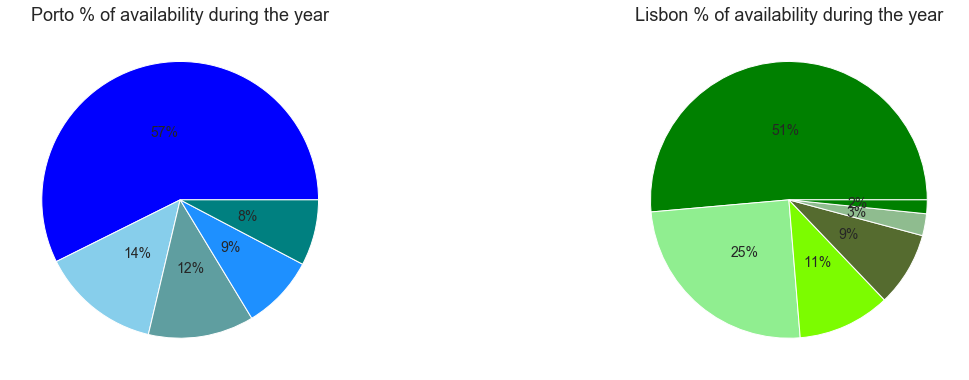

In [55]:
fig = plt.figure(figsize = (20,14))

colors_l = ['green', 'lightgreen', 'lawngreen', 'darkolivegreen', 'darkseagreen']
colors_p = ['blue', 'skyblue', 'cadetblue', 'dodgerblue', 'teal']

plt.subplot(2,2,1)
#labels = ['whole year', 'up to half a year', 'up to 90 days', 'up to 270 days']
plt.pie(avai_per_porto, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2, textprops={'fontsize': 14}, colors = colors_p)
plt.title('Porto % of availability during the year')

plt.subplot(2,2,2)
plt.pie(avai_per_lisbon, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2, textprops={'fontsize': 14}, colors = colors_l)
plt.title('Lisbon % of availability during the year')


## What was airbnb's growth since the first scraped listings

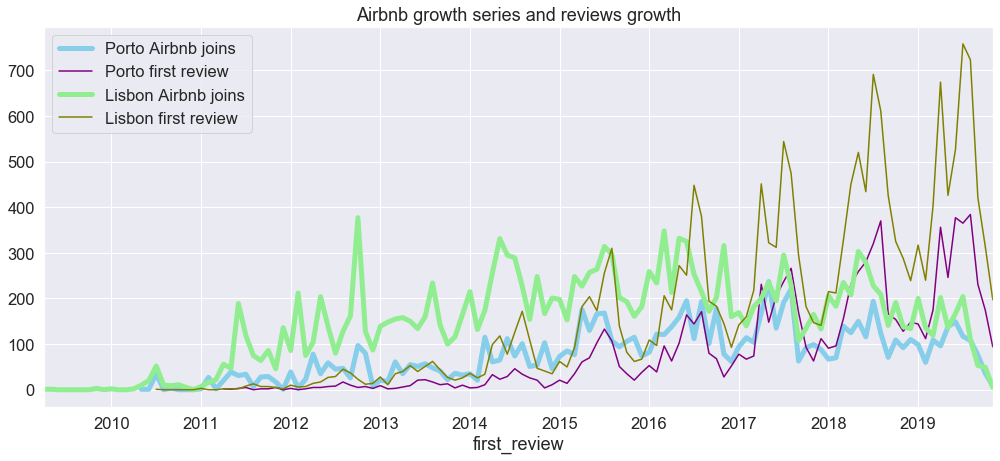

In [56]:
plt.figure(figsize=(17,7))
porto_listings_plus.set_index('host_since').resample('MS').size().plot(label='Porto Airbnb joins', color='skyblue', linewidth = 5)
porto_listings_plus.set_index('first_review').resample('MS').size().plot(label='Porto first review', color='purple')
lisbon_listings_plus.set_index('host_since').resample('MS').size().plot(label='Lisbon Airbnb joins', color='lightgreen', linewidth = 5)
lisbon_listings_plus.set_index('first_review').resample('MS').size().plot(label='Lisbon first review', color='olive')
plt.title('Airbnb growth series and reviews growth')
plt.legend()
plt.show()

## Princing is one of the factors of focus on this exploration, are there outliers to it?

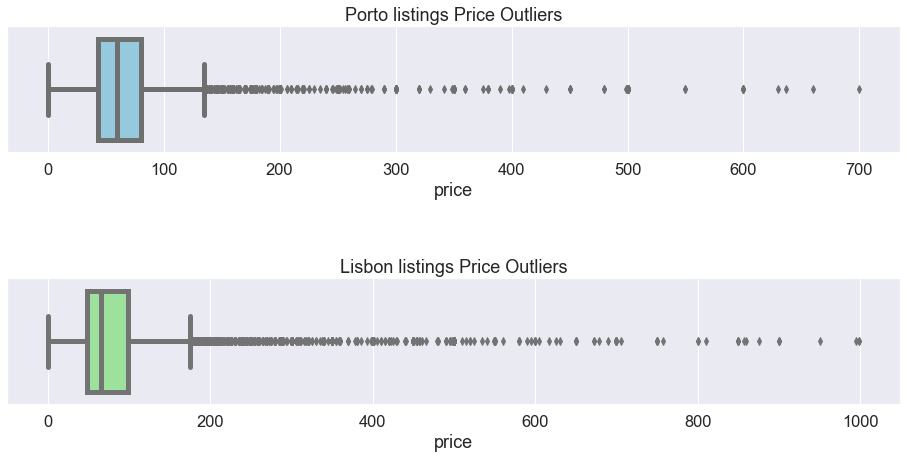

In [57]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.boxplot(x = porto_listings_m['price'], ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto listings Price Outliers')

ax1 = sns.boxplot(x = lisbon_listings_m['price'], ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon listings Price Outliers')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

I am curious on what makes some properties so much more expensive than the average, I wonder if there is a luxury market

In [58]:
#sorting based on listing price
porto_listings_m.sort_values(by = 'price', ascending = False, axis = 0, inplace = True)
lisbon_listings_m.sort_values(by = 'price', ascending = False, axis = 0, inplace = True)

#and setting up a minimal df for the top listings
porto_top_price = porto_listings_m.head(50)
lisbon_top_price = lisbon_listings_m.head(50)

In [59]:
porto_top_price.head()

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available
7232,34746357,1,1,155005113,Gonçalo,2017-10-17,"Porto, Porto District, Portugal",within an hour,100.0,t,2.0,t,f,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.16315,-8.63171,t,Apartment,Entire home/apt,4,1.0,1.0,3.0,"{TV,Wifi,Kitchen,Elevator,""Free street parking...",700.0,1,1,0.0,2,t,138,12,2019-08-10,2019-11-02,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,3.24,1,1,1,1,37.808219
4754,24646540,0,0,124472632,João,2017-04-05,"Porto, Porto District, Portugal",within an hour,91.0,f,28.0,t,f,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.16105,-8.62371,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",660.0,1,1,5.0,2,t,359,1,2018-06-12,2018-06-12,80.0,10.0,10.0,10.0,10.0,10.0,10.0,t,flexible,f,f,0.06,1,1,1,1,98.356164
6928,33634139,1,1,98624058,Yes! Porto,2016-10-07,PT,within an hour,95.0,f,3.0,t,f,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.14645,-8.61465,t,Hostel,Hotel room,12,0.0,1.0,4.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",637.0,0,0,0.0,1,t,359,7,2019-05-15,2019-11-06,97.0,10.0,9.0,10.0,10.0,10.0,10.0,t,flexible,f,f,1.06,1,1,1,1,98.356164
1324,10605132,0,0,27267172,Marcos,2015-02-05,"Viseu District, Portugal",within an hour,100.0,t,8.0,t,t,Lordelo do Ouro e Massarelos,PORTO,41.14838,-8.63308,t,House,Entire home/apt,16,7.0,7.0,10.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets allo...",630.0,0,1,100.0,1,t,0,64,2016-02-17,2019-10-25,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,1.39,1,1,1,1,75.890411
6774,32991699,1,1,191156089,Fernando,2018-05-23,"Allahabad, Uttar Pradesh, India",within a few hours,100.0,t,1.0,t,f,Canidelo,VILA NOVA DE GAIA,41.13099,-8.67009,f,Villa,Entire home/apt,16,4.0,5.0,14.0,"{TV,""Cable TV"",Wifi,Pool,Kitchen,""Free parking...",600.0,1,1,35.0,1,t,328,22,2019-04-08,2019-11-12,97.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,f,f,2.81,1,1,1,1,89.835165


In [60]:
lisbon_top_price.head()

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available
16336,36834595,1,1,276843836,Zélia,2019-07-17,PT,within an hour,100.0,f,0.0,t,f,Misericrdia,Lisboa,38.71362,-9.14407,t,Apartment,Entire home/apt,5,2.0,3.0,4.0,"{TV,""Cable TV"",Wifi,Kitchen,Washer,""Smoke dete...",999.0,1,1,20.0,3,t,346,11,2019-07-26,2019-11-06,85.0,9.0,9.0,9.0,9.0,9.0,9.0,t,strict_14_with_grace_period,f,f,2.62,1,1,1,1,NaN
16158,36400980,1,1,273702328,Menal,2019-07-05,"Lisbon, Lisbon, Portugal",within a day,100.0,f,0.0,t,f,Arroios,Lisboa,38.72572,-9.13412,t,Apartment,Entire home/apt,5,2.0,2.0,2.0,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,W...",999.0,1,1,15.0,3,t,353,8,2019-08-08,2019-11-11,93.0,10.0,9.0,10.0,9.0,9.0,9.0,t,strict_14_with_grace_period,f,f,2.12,1,1,1,1,NaN
4238,12172359,1,1,16696225,Aline,2014-06-12,Monaco,within a few hours,90.0,f,4.0,t,f,"S.Maria, S.Miguel, S.Martinho, S.Pedro Penaferrim",Sintra,38.79263,-9.40824,f,House,Entire home/apt,13,8.0,5.0,7.0,"{TV,""Cable TV"",Internet,Wifi,Pool,Kitchen,""Fre...",995.0,0,1,70.0,5,t,317,5,2016-07-28,2019-08-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,0.12,1,1,1,1,76.142132
11946,27157166,1,1,62521369,Maria,2016-03-11,"Lisbon, Lisbon, Portugal",within an hour,100.0,f,45.0,t,f,So Vicente,Lisboa,38.71931,-9.13143,t,Apartment,Entire home/apt,10,4.0,4.0,5.0,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",950.0,1,1,0.0,2,t,322,55,2018-08-09,2019-11-16,98.0,10.0,10.0,10.0,10.0,10.0,9.0,t,moderate,f,f,3.46,1,1,1,1,NaN
4889,13663995,1,1,48672786,Intendente 1865 - Apartments -,2015-11-10,"Lisbon, Lisbon, Portugal",within an hour,100.0,t,8.0,t,t,Arroios,Lisboa,38.72218,-9.13380,t,Serviced apartment,Hotel room,16,12.0,12.0,18.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",900.0,1,1,12.0,2,t,339,35,2017-05-21,2019-09-30,95.0,9.0,10.0,10.0,10.0,9.0,9.0,t,moderate,f,f,1.14,1,1,1,1,58.758315


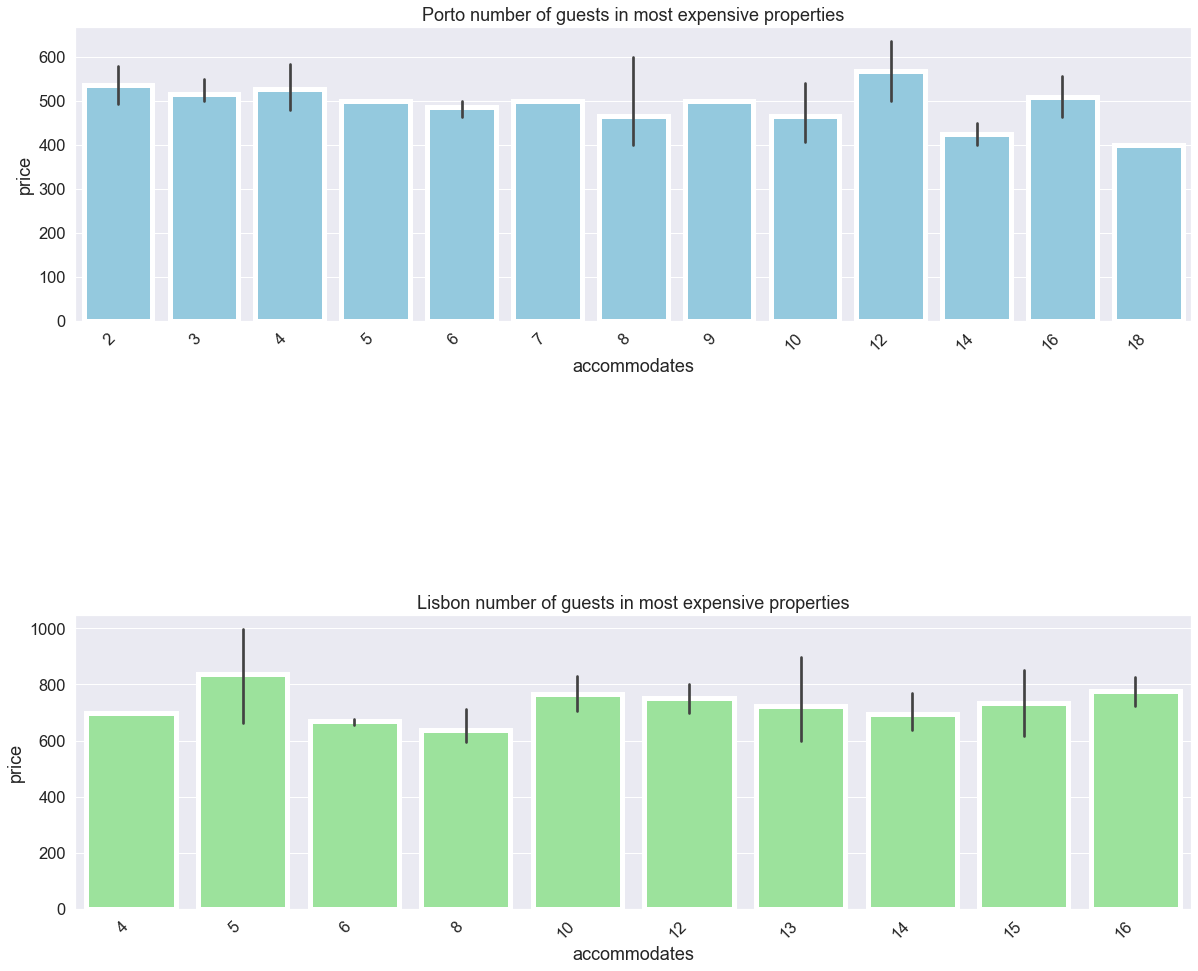

In [61]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'accommodates', y = 'price', data = porto_top_price, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto number of guests in most expensive properties')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'accommodates', y = 'price', data = lisbon_top_price, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon number of guests in most expensive properties')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

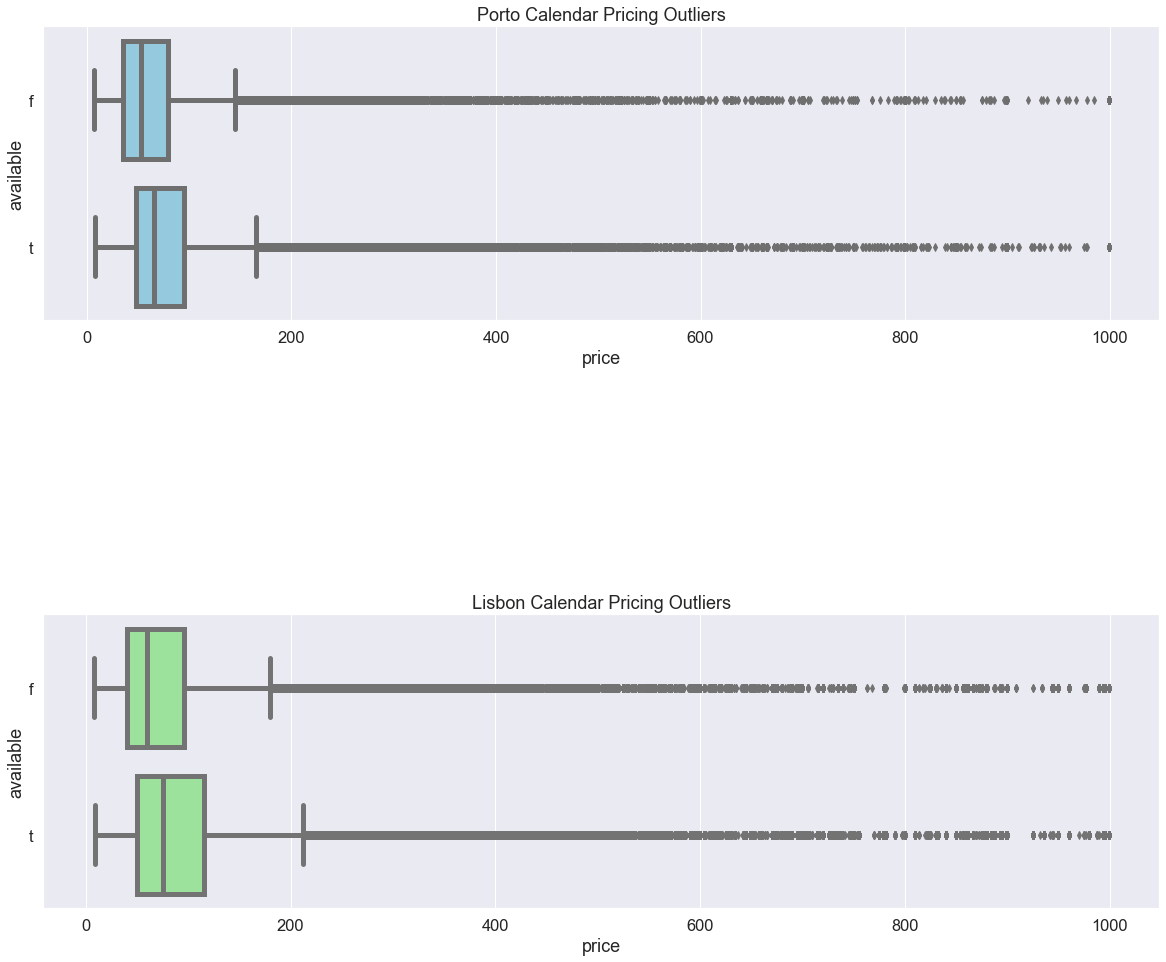

In [62]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


ax1 = sns.boxplot(x = porto_calendar_m['price'], y = porto_calendar['available'], ax = ax1, color = 'skyblue',  linewidth = 5)
ax1.set_title('Porto Calendar Pricing Outliers')

ax1 = sns.boxplot(x = lisbon_calendar_m['price'], y = lisbon_calendar['available'], ax = ax2, color = 'lightgreen', linewidth = 5 )
ax2.set_title('Lisbon Calendar Pricing Outliers')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

I suspect that these outliers correspond to the luxury market which can skew the prediction further down the exploration

In [63]:
porto_listings_m['price'].describe()

count    8361.000000
mean       71.009449
std        54.768810
min         0.000000
25%        43.000000
50%        60.000000
75%        80.000000
max       700.000000
Name: price, dtype: float64

In [64]:
lisbon_listings_m['price'].describe()

count    17203.000000
mean        83.918212
std         71.271519
min          0.000000
25%         48.000000
50%         66.000000
75%         99.000000
max        999.000000
Name: price, dtype: float64

Aparently some of the prices actually have a min of 0 dollars which makes no sense so I will remove those. 
Further down it will be important to create a feature corresponding to the price per guest so I can further filter out properties that correspond to the luxury market/outliers.

## Some hosts have multiple listings, which hosts have the greatest number of listings? What if we base the counts on their review scores rating? 

In [65]:
porto_listings_m.head()

,id,space,transit,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,extra_people,minimum_nights,has_availability,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available
7232,34746357,1,1,155005113,Gonçalo,2017-10-17,"Porto, Porto District, Portugal",within an hour,100.0,t,2.0,t,f,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.16315,-8.63171,t,Apartment,Entire home/apt,4,1.0,1.0,3.0,"{TV,Wifi,Kitchen,Elevator,""Free street parking...",700.0,1,1,0.0,2,t,138,12,2019-08-10,2019-11-02,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,3.24,1,1,1,1,37.808219
4754,24646540,0,0,124472632,João,2017-04-05,"Porto, Porto District, Portugal",within an hour,91.0,f,28.0,t,f,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.16105,-8.62371,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,"{TV,Wifi,Kitchen,""Free parking on premises"",""P...",660.0,1,1,5.0,2,t,359,1,2018-06-12,2018-06-12,80.0,10.0,10.0,10.0,10.0,10.0,10.0,t,flexible,f,f,0.06,1,1,1,1,98.356164
6928,33634139,1,1,98624058,Yes! Porto,2016-10-07,PT,within an hour,95.0,f,3.0,t,f,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",PORTO,41.14645,-8.61465,t,Hostel,Hotel room,12,0.0,1.0,4.0,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",637.0,0,0,0.0,1,t,359,7,2019-05-15,2019-11-06,97.0,10.0,9.0,10.0,10.0,10.0,10.0,t,flexible,f,f,1.06,1,1,1,1,98.356164
1324,10605132,0,0,27267172,Marcos,2015-02-05,"Viseu District, Portugal",within an hour,100.0,t,8.0,t,t,Lordelo do Ouro e Massarelos,PORTO,41.14838,-8.63308,t,House,Entire home/apt,16,7.0,7.0,10.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets allo...",630.0,0,1,100.0,1,t,0,64,2016-02-17,2019-10-25,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,1.39,1,1,1,1,75.890411
6774,32991699,1,1,191156089,Fernando,2018-05-23,"Allahabad, Uttar Pradesh, India",within a few hours,100.0,t,1.0,t,f,Canidelo,VILA NOVA DE GAIA,41.13099,-8.67009,f,Villa,Entire home/apt,16,4.0,5.0,14.0,"{TV,""Cable TV"",Wifi,Pool,Kitchen,""Free parking...",600.0,1,1,35.0,1,t,328,22,2019-04-08,2019-11-12,97.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,f,f,2.81,1,1,1,1,89.835165


Creating bins for the availability of listings

In [66]:
#copy df to temp df
temp_porto = porto_listings_m.copy()
temp_lisbon = lisbon_listings_m.copy()

#create bins
temp_porto.availability_365 = pd.cut(temp_porto.availability_365, bins = [0, 90, 180, 270, 365], include_lowest = True)
temp_lisbon.availability_365 = pd.cut(temp_lisbon.availability_365, bins = [0, 90, 180, 270, 365], include_lowest = True)

# Converting to string
temp_porto.availability_365 = temp_porto.availability_365.astype('str')
temp_lisbon.availability_365 = temp_lisbon.availability_365.astype('str')

# Category counts
temp_porto.availability_365.value_counts()
temp_lisbon.availability_365.value_counts()


(270.0, 365.0]    9842
(90.0, 180.0]     2594
(-0.001, 90.0]    2536
(180.0, 270.0]    2231
Name: availability_365, dtype: int64

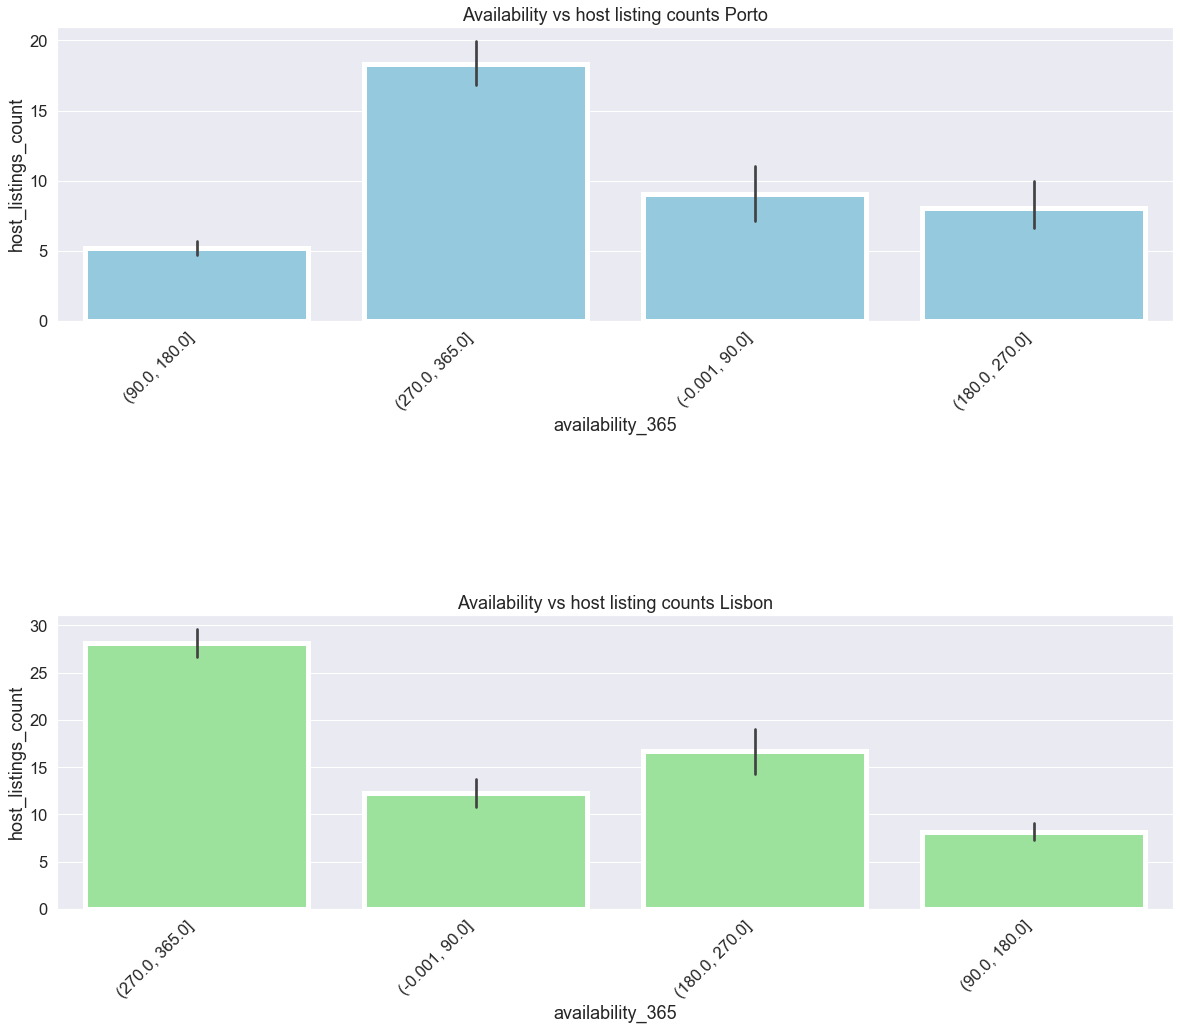

In [67]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'availability_365' , y = 'host_listings_count', data = temp_porto, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Availability vs host listing counts Porto')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'availability_365' , y = 'host_listings_count', data = temp_lisbon, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Availability vs host listing counts Lisbon')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

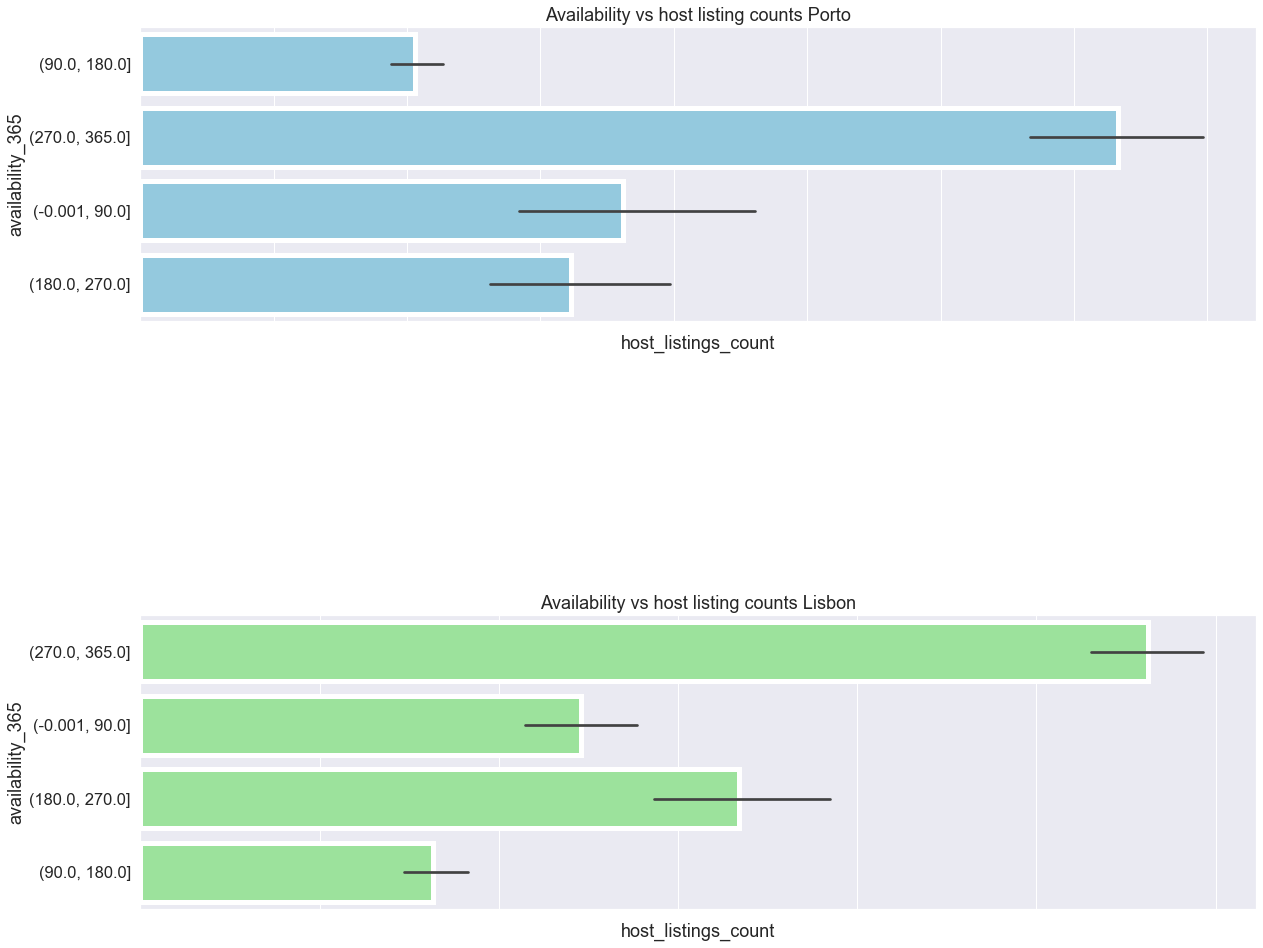

In [68]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'host_listings_count' , y = 'availability_365', data = temp_porto, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Availability vs host listing counts Porto')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'host_listings_count' , y = 'availability_365', data = temp_lisbon, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Availability vs host listing counts Lisbon')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

In [69]:
#copy df to temp df
temp_porto2 = porto_listings_m.copy()
temp_lisbon2 = lisbon_listings_m.copy()

#create bins
temp_porto2.availability_365 = pd.cut(temp_porto2.availability_365, bins = [0, 90, 180, 270, 365], include_lowest = True)
temp_lisbon2.availability_365 = pd.cut(temp_lisbon2.availability_365, bins = [0, 90, 180, 270, 365], include_lowest = True)

#grouping based on availability
avai_per_porto = temp_porto2['availability_365'].value_counts(normalize = True)*100
avai_per_lisbon = temp_lisbon2['availability_365'].value_counts(normalize = True)*100


#create bins for number of listings
temp_porto2.host_listings_count = pd.cut(temp_porto2.host_listings_count, bins = [0, 2, 5, 10, 20, 600], include_lowest = True)
temp_lisbon2.host_listings_count = pd.cut(temp_lisbon2.host_listings_count, bins = [0, 2, 5, 10, 20, 600], include_lowest = True)

#grouping based on listings
list_per_porto = temp_porto2['host_listings_count'].value_counts(normalize = True)*100
list_per_lisbon = temp_lisbon2['host_listings_count'].value_counts(normalize = True)*100

In [70]:
avai_per_porto.head()

(270.0, 365.0]    61.547662
(90.0, 180.0]     14.328430
(-0.001, 90.0]    12.701830
(180.0, 270.0]    11.422079
Name: availability_365, dtype: float64

In [71]:
avai_per_lisbon.head()

(270.0, 365.0]    57.210952
(90.0, 180.0]     15.078765
(-0.001, 90.0]    14.741615
(180.0, 270.0]    12.968668
Name: availability_365, dtype: float64

In [72]:
list_per_porto.head()

(-0.001, 2.0]    41.011841
(2.0, 5.0]       23.394331
(5.0, 10.0]      15.141729
(20.0, 600.0]    12.570267
(10.0, 20.0]      7.881832
Name: host_listings_count, dtype: float64

In [73]:
list_per_lisbon.head()

(-0.001, 2.0]    37.336511
(2.0, 5.0]       20.205778
(20.0, 600.0]    16.020462
(5.0, 10.0]      13.782480
(10.0, 20.0]     12.654770
Name: host_listings_count, dtype: float64

Text(0.5, 1.0, 'Lisbon % of listing counts per host')

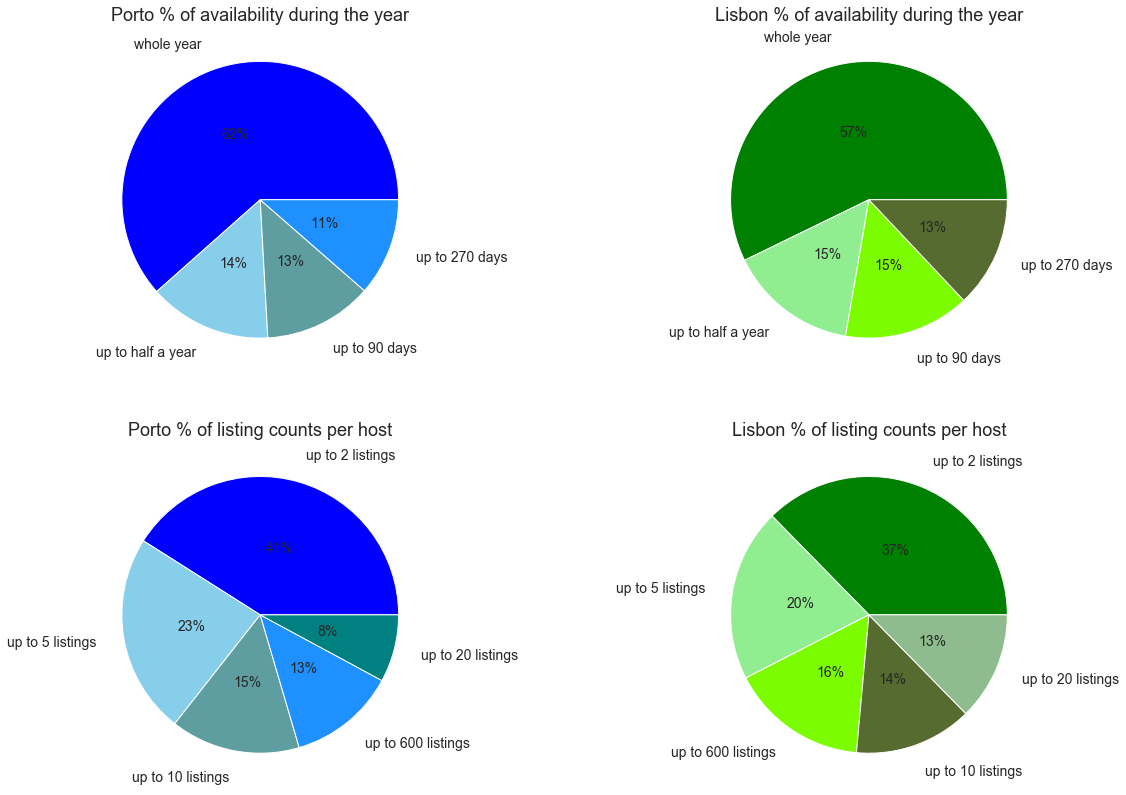

In [74]:
fig = plt.figure(figsize = (20,14))

colors_l = ['green', 'lightgreen', 'lawngreen', 'darkolivegreen']
colors_p = ['blue', 'skyblue', 'cadetblue', 'dodgerblue']

plt.subplot(2,2,1)
labels = ['whole year', 'up to half a year', 'up to 90 days', 'up to 270 days']
plt.pie(avai_per_porto, labels = labels, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2, textprops={'fontsize': 14}, colors = colors_p)
plt.title('Porto % of availability during the year')

plt.subplot(2,2,2)
plt.pie(avai_per_lisbon, labels = labels, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2, textprops={'fontsize': 14}, colors = colors_l)
plt.title('Lisbon % of availability during the year')

labels2p = ["up to 2 listings", "up to 5 listings", "up to 10 listings", 'up to 600 listings', "up to 20 listings"]
labels2l = ["up to 2 listings", "up to 5 listings", 'up to 600 listings', "up to 10 listings", "up to 20 listings"]
colors_l2 = ['green', 'lightgreen', 'lawngreen', 'darkolivegreen', 'darkseagreen']
colors_p2 = ['blue', 'skyblue', 'cadetblue', 'dodgerblue', 'teal']

plt.subplot(2,2,3)
labels = ['whole year', 'up to half a year', 'up to 90 days', 'up to 270 days']
plt.pie(list_per_porto, labels = labels2p, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2, textprops={'fontsize': 14}, colors = colors_p2)
plt.title('Porto % of listing counts per host')

plt.subplot(2,2,4)
plt.pie(list_per_lisbon, labels = labels2l, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2, textprops={'fontsize': 14}, colors = colors_l2)
plt.title('Lisbon % of listing counts per host')

In [75]:
temp_porto2.host_listings_count.value_counts()

(-0.001, 2.0]    3429
(2.0, 5.0]       1956
(5.0, 10.0]      1266
(20.0, 600.0]    1051
(10.0, 20.0]      659
Name: host_listings_count, dtype: int64

In [76]:
temp_lisbon2.host_listings_count.value_counts()

(-0.001, 2.0]    6423
(2.0, 5.0]       3476
(20.0, 600.0]    2756
(5.0, 10.0]      2371
(10.0, 20.0]     2177
Name: host_listings_count, dtype: int64

In [77]:
#sorting based on listing counts
porto_listings_m.sort_values(by = 'host_listings_count', ascending = False, axis = 0, inplace = True)
lisbon_listings_m.sort_values(by = 'host_listings_count', ascending = False, axis = 0, inplace = True)

#and setting up a minimal df for the top listings
porto_top_list_counts = porto_listings_m.head(600)
lisbon_top_list_counts = lisbon_listings_m.head(1025)

#since there are many duplicates in the rows I will drop some of them
porto_top_list_counts_dedup = porto_top_list_counts.drop_duplicates(subset = 'host_id', keep = 'last')
lisbon_top_list_counts_dedup = lisbon_top_list_counts.drop_duplicates(subset = 'host_id', keep = 'last')

In [78]:
porto_top_list_counts_dedup.shape

(19, 52)

In [79]:
lisbon_top_list_counts_dedup.shape

(19, 52)

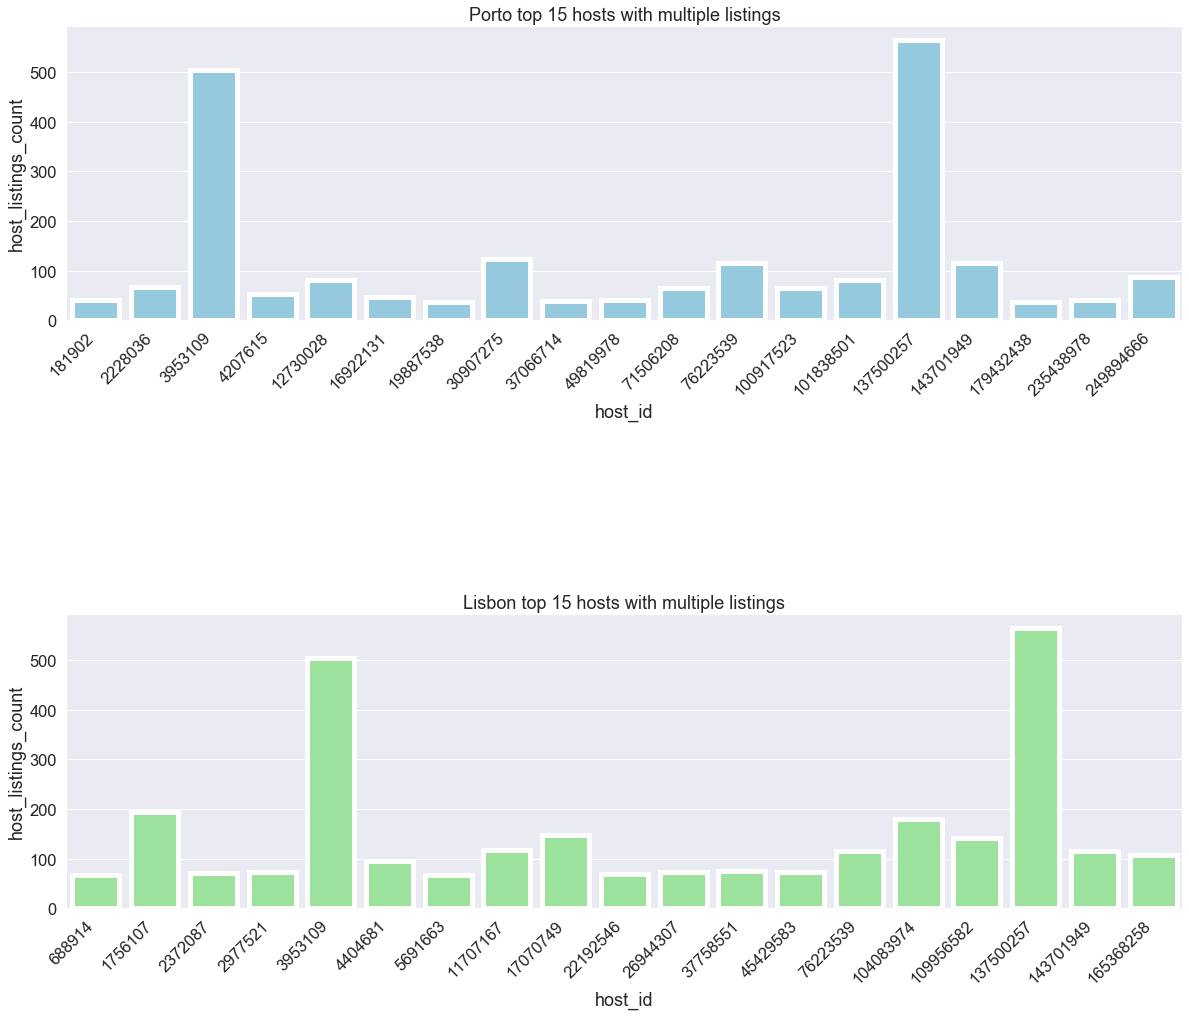

In [80]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'host_id', y = 'host_listings_count', data = porto_top_list_counts_dedup, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto top 15 hosts with multiple listings')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'host_id', y = 'host_listings_count', data = lisbon_top_list_counts_dedup, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon top 15 hosts with multiple listings')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


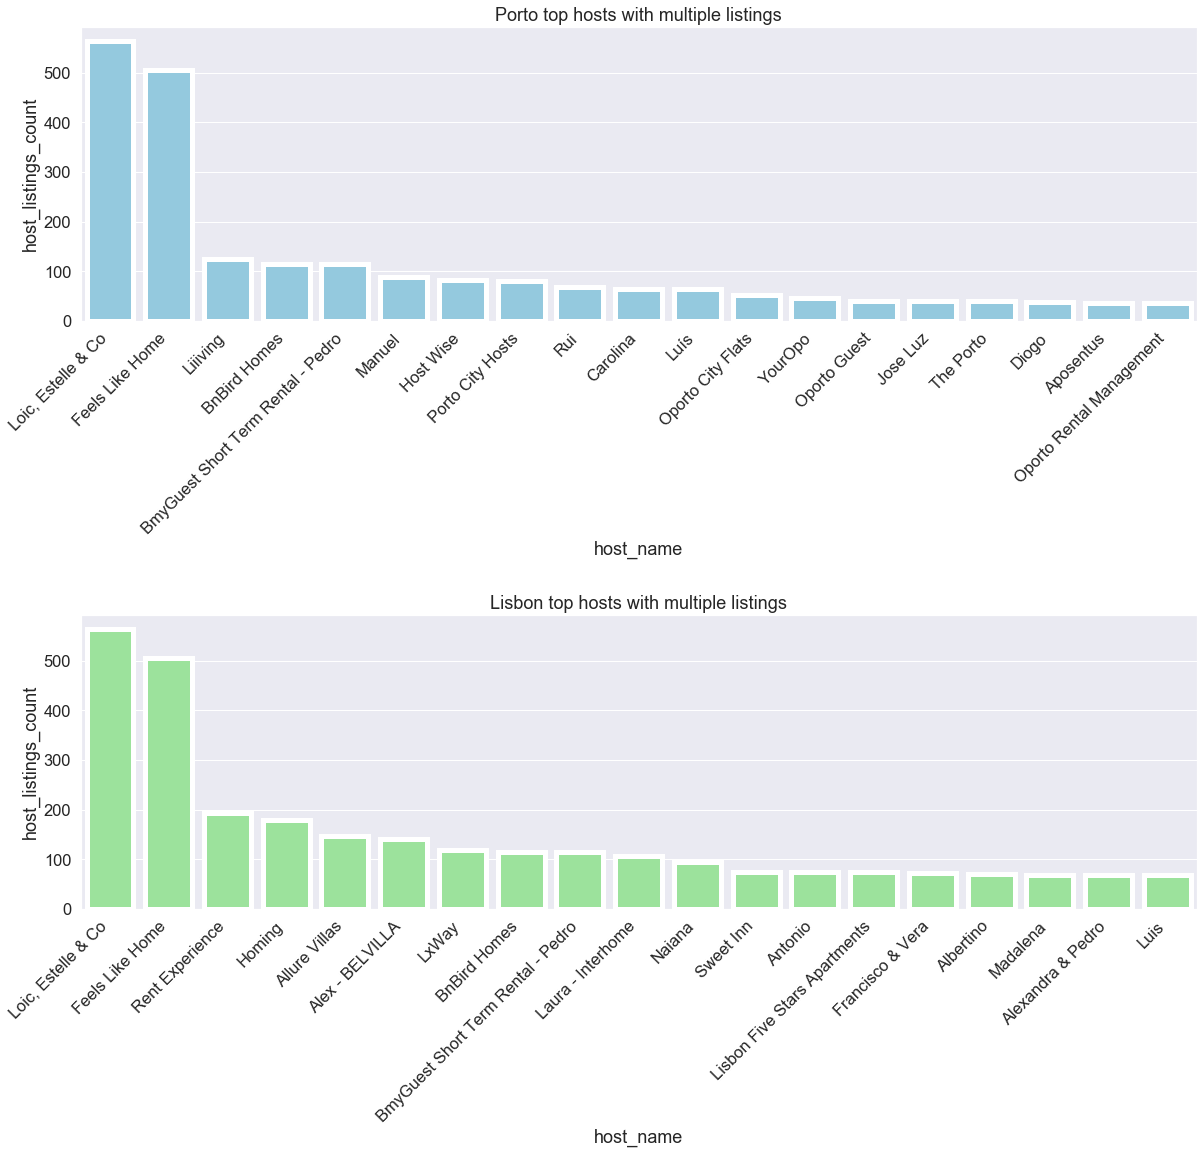

In [81]:
#sorting based on listing counts
porto_top_list_counts_dedup.sort_values(by = 'host_listings_count', ascending = False, axis = 0, inplace = True)
lisbon_top_list_counts_dedup.sort_values(by = 'host_listings_count', ascending = False, axis = 0, inplace = True)

fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'host_name', y = 'host_listings_count', data = porto_top_list_counts_dedup, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto top hosts with multiple listings')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'host_name', y = 'host_listings_count', data = lisbon_top_list_counts_dedup, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon top hosts with multiple listings')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

## Are the companies with the greatest number of listings the ones with higher review scores?

In [82]:
#sorting based on reviews
porto_listings_m.sort_values(by = 'review_scores_rating', ascending = False, axis = 0, inplace = True)
lisbon_listings_m.sort_values(by = 'review_scores_rating', ascending = False, axis = 0, inplace = True)

#and setting up a minimal df for the top listings
porto_toprev = porto_listings_m.head(50)
lisbon_toprev = lisbon_listings_m.head(50)

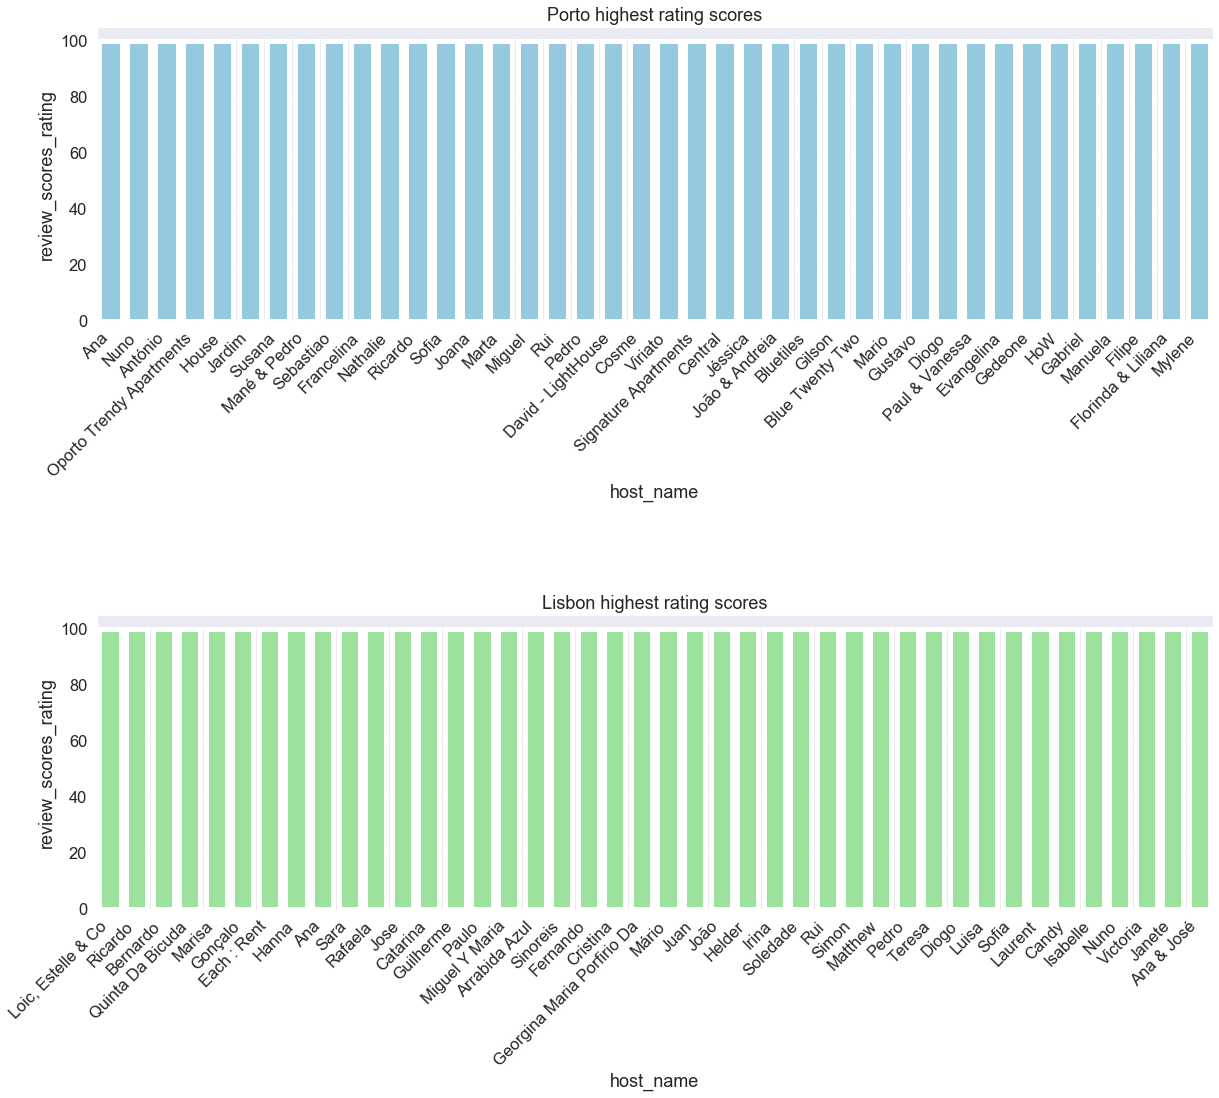

In [83]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'host_name', y = 'review_scores_rating', data = porto_toprev, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto highest rating scores')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'host_name', y = 'review_scores_rating', data = lisbon_toprev, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon highest rating scores')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

In [84]:
#copy df to temp df
temp_porto3 = porto_listings_m.copy()
temp_lisbon3 = lisbon_listings_m.copy()

temp_porto3.review_scores_rating = pd.cut(temp_porto3.review_scores_rating, bins = [0, 80, 85, 90, 95, 100], include_lowest=True)
temp_lisbon3.review_scores_rating = pd.cut(temp_lisbon3.review_scores_rating, bins = [0, 80, 85, 90, 95, 100], include_lowest=True)

# Converting to string
temp_porto3.review_scores_rating = temp_porto3.review_scores_rating.astype('str')
temp_lisbon3.review_scores_rating = temp_lisbon3.review_scores_rating.astype('str')

# Category counts
temp_porto3.review_scores_rating.value_counts()
temp_lisbon3.review_scores_rating.value_counts()


(95.0, 100.0]     7373
(90.0, 95.0]      5071
(85.0, 90.0]      2600
(-0.001, 80.0]    1225
(80.0, 85.0]       934
Name: review_scores_rating, dtype: int64

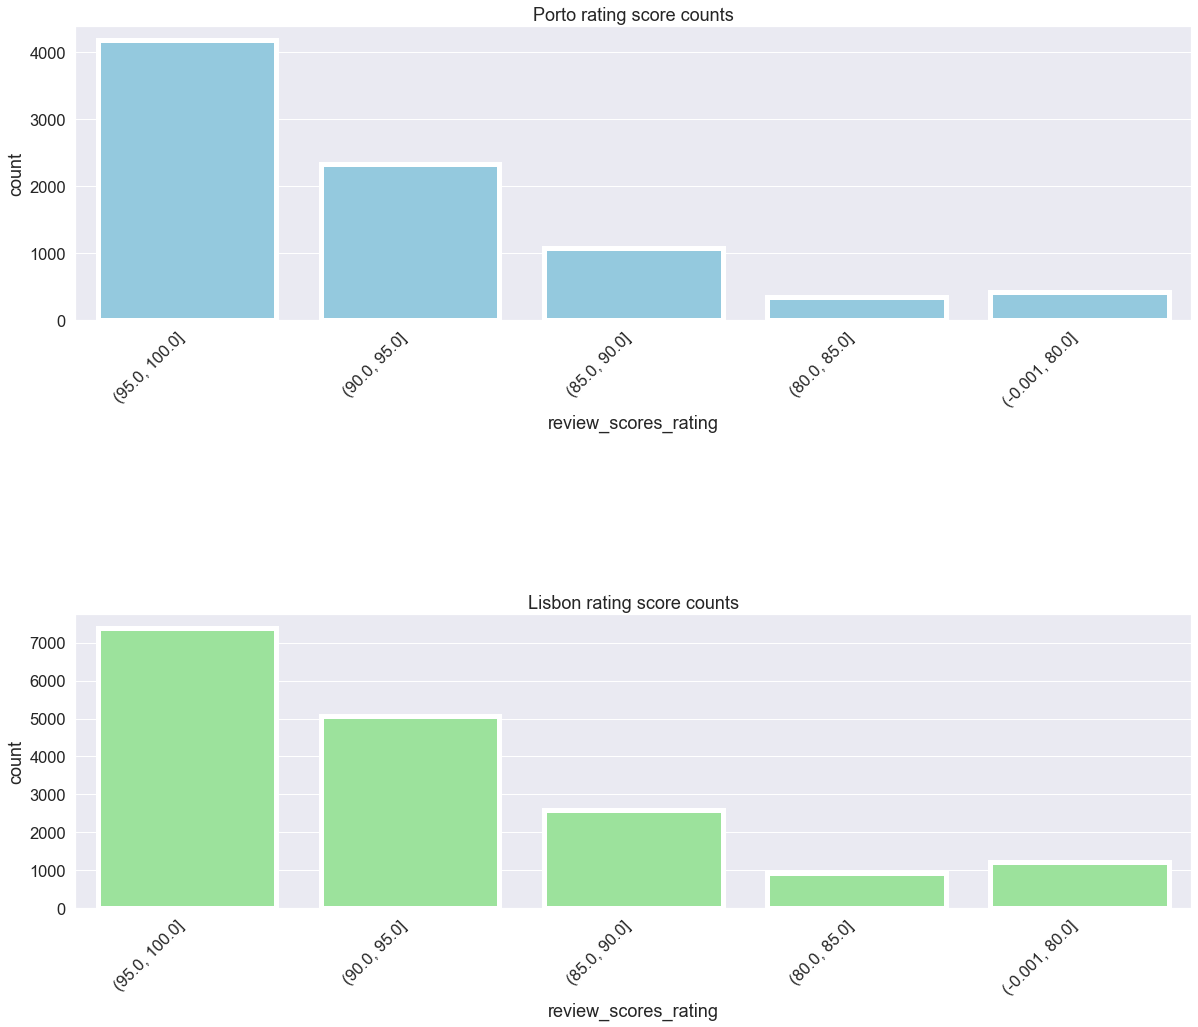

In [85]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.countplot(x = 'review_scores_rating', data = temp_porto3, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto rating score counts')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.countplot(x = 'review_scores_rating', data = temp_lisbon3, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon rating score counts')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

## Which hosts have the highest amount of reviews per month?

In [86]:
#sorting based on reviews
porto_listings_m.sort_values(by = 'reviews_per_month', ascending = False, axis = 0, inplace = True)
lisbon_listings_m.sort_values(by = 'reviews_per_month', ascending = False, axis = 0, inplace = True)

#and setting up a minimal df for the top listings
porto_toprev = porto_listings_m.head(50)
lisbon_toprev = lisbon_listings_m.head(50)

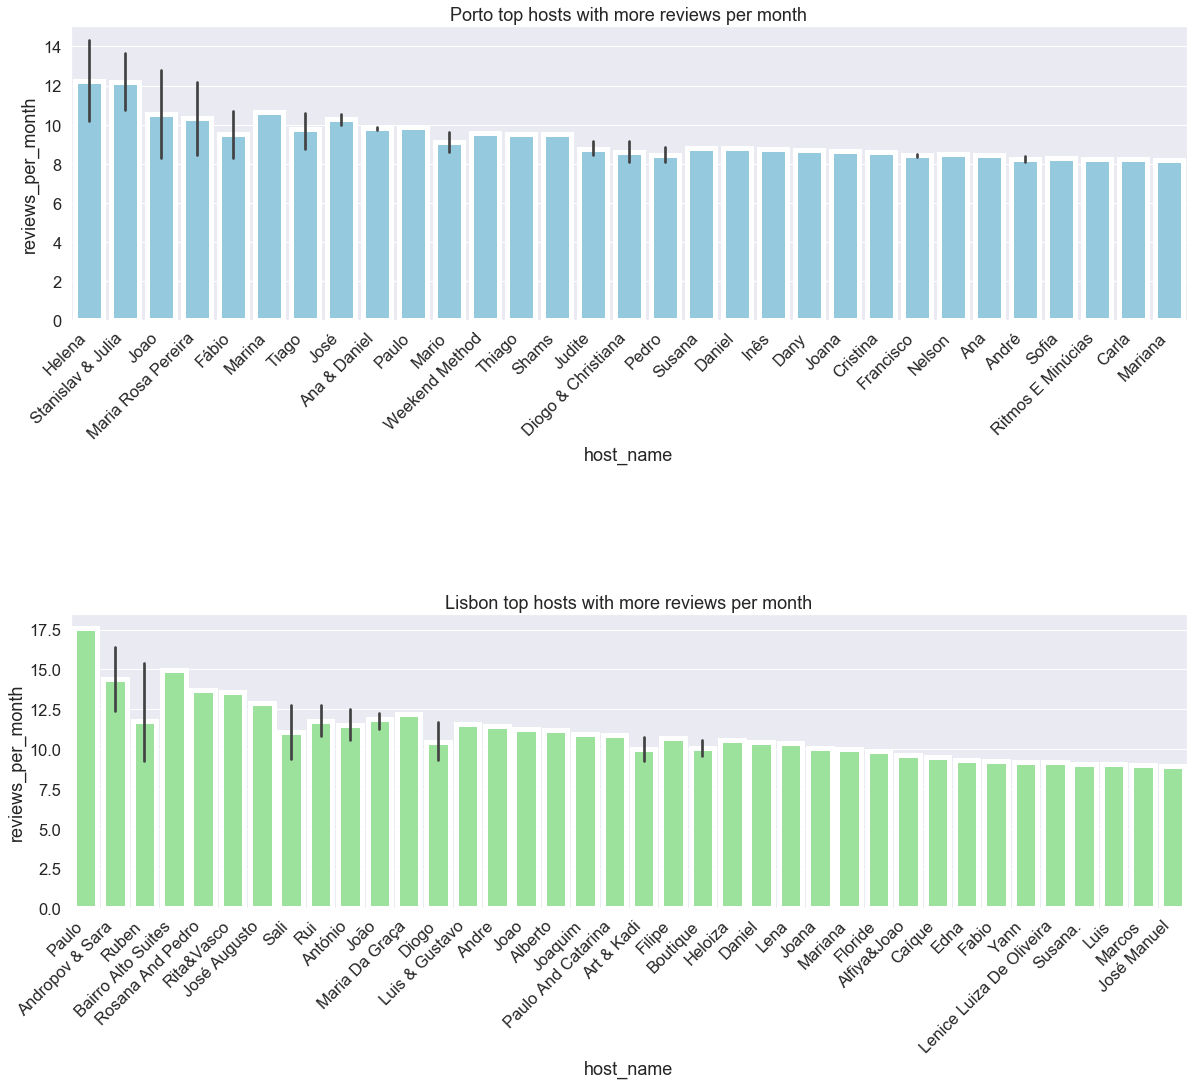

In [87]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.barplot(x = 'host_name', y = 'reviews_per_month', data = porto_toprev, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto top hosts with more reviews per month')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.barplot(x = 'host_name', y = 'reviews_per_month', data = lisbon_toprev, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon top hosts with more reviews per month')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

which are the names behind these ids?
lisbon_listings.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).nlargest(20)

Well it seems like quantity is not quality, the listings with the most reviews per month do not match the hosts with the biggest number of listings.

## Which are the most popular neighbourhoods in the two cities?

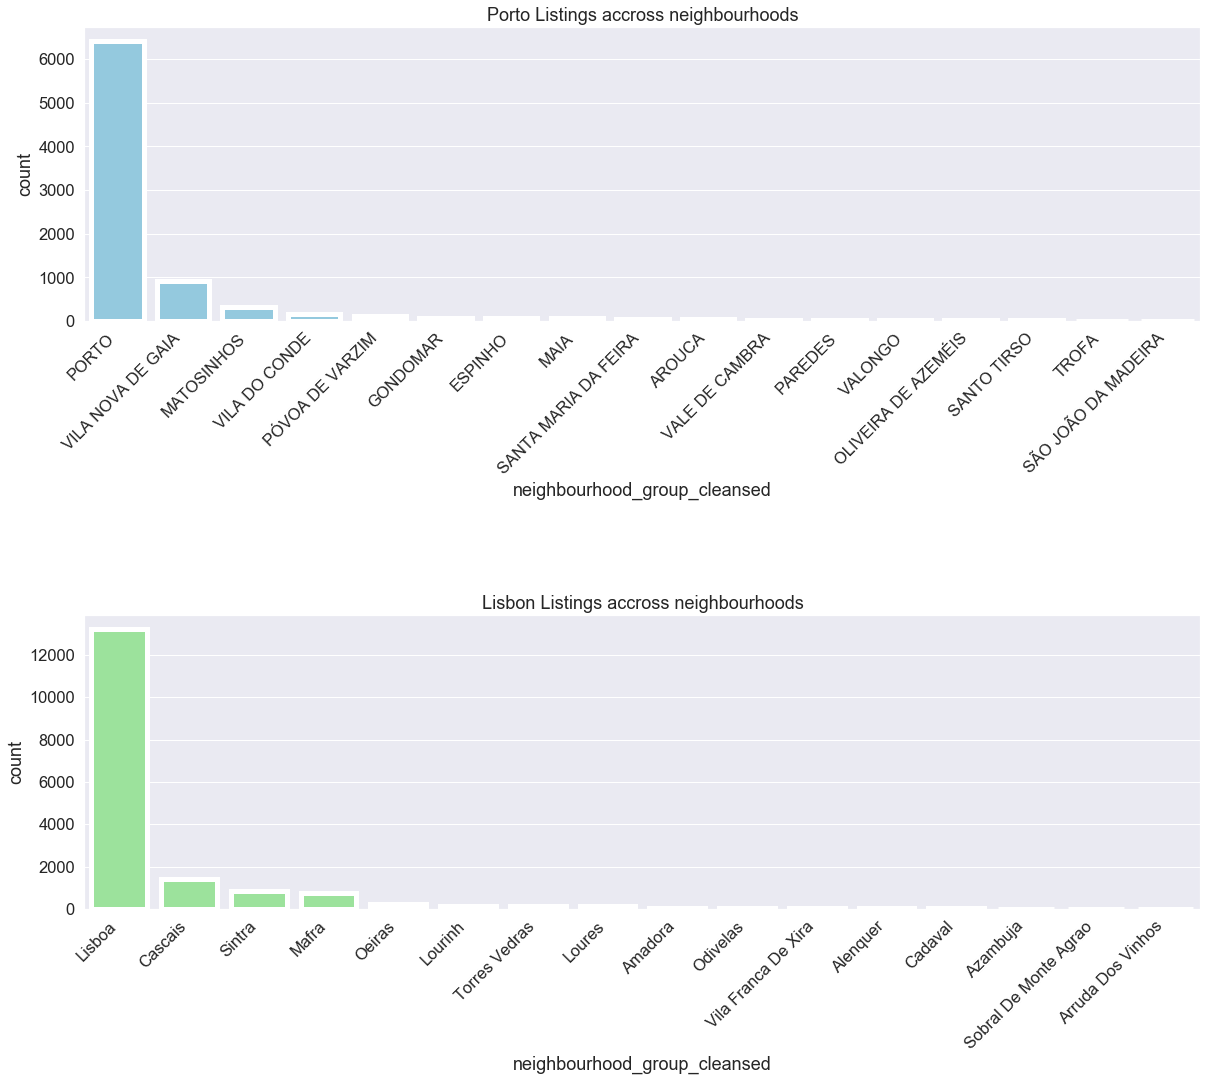

In [88]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.countplot(x = 'neighbourhood_group_cleansed', data = porto_listings_m,
                    order = porto_listings_m.neighbourhood_group_cleansed.value_counts().sort_values(ascending=False).index, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto Listings accross neighbourhoods')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.countplot(x = 'neighbourhood_group_cleansed', data = lisbon_listings_m,
                    order = lisbon_listings_m.neighbourhood_group_cleansed.value_counts().sort_values(ascending=False).index, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon Listings accross neighbourhoods')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

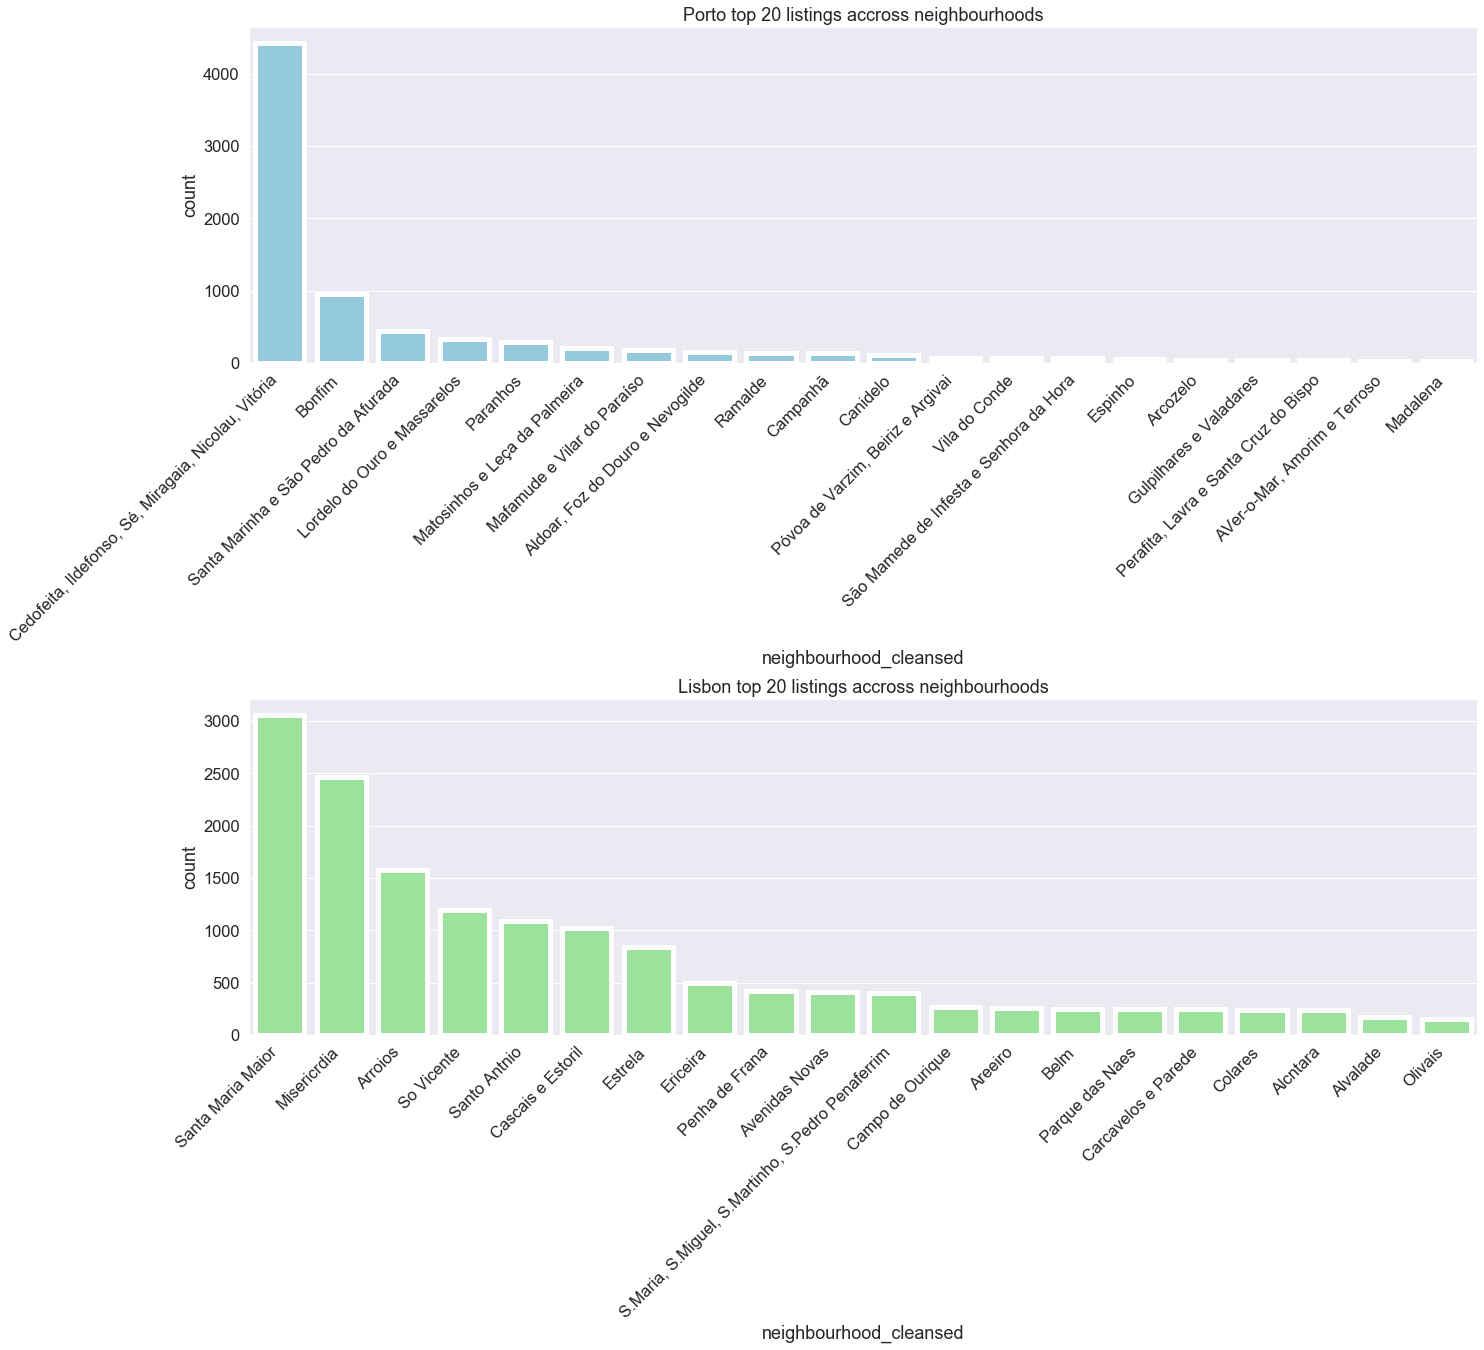

In [89]:
fig = plt.figure(figsize = (22,16))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.countplot(x = 'neighbourhood_cleansed', data = porto_listings_m,
                    order = porto_listings_m.neighbourhood_cleansed.value_counts().iloc[:20].sort_values(ascending=False).index, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto top 20 listings accross neighbourhoods')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.countplot(x = 'neighbourhood_cleansed', data = lisbon_listings_m,
                    order = lisbon_listings_m.neighbourhood_cleansed.value_counts().iloc[:20].sort_values(ascending=False).index, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon top 20 listings accross neighbourhoods')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

Time to map-up the most popular listings


I will select only the top 1000 listings based on their reviews



lisbon coordinates: 38.736946, -9.142685.



porto coordinates: 41.14961, -8.61099

## I will now map some of the properties with the highest review scores

In [90]:
#sorting based on reviews
porto_listings_m.sort_values(by = 'review_scores_rating', ascending = False, axis = 0, inplace = True)
lisbon_listings_m.sort_values(by = 'review_scores_rating', ascending = False, axis = 0, inplace = True)

#and setting up a minimal df for the top listings
porto_top1000 = porto_listings_m.head(1000)
lisbon_top1000 = lisbon_listings_m.head(1000)

In [91]:
#creating a base maps
lat_l = 38.736946
long_l = -9.142685

lat_p = 41.14961
long_p = -8.61099

base_l = folium.Map(location=[lat_l,long_l], zoom_start=12)
base_p = folium.Map(location=[lat_p,long_p], zoom_start=12)

neighbourhoods = folium.map.FeatureGroup()

In [148]:
#mapping porto
for lati, longi in zip(porto_top1000.longitude, porto_top1000.latitude):
    neighbourhoods.add_child(folium.CircleMarker([longi, lati], radius = 2, color = 'blue', fill = True))

base_p.add_child(neighbourhoods)
neighbourhoods.save('Porto.html')

In [149]:
#mapping lisbon
for lati, longi in zip(lisbon_top1000.longitude, lisbon_top1000.latitude):
    neighbourhoods.add_child(folium.CircleMarker([longi, lati], radius = 2, color = 'green', fill = True))

base_l.add_child(neighbourhoods)
neighbourhoods.save('Lisbon.html')

## Is there seasonality to the listings prices? 

In [94]:
#determining the mean values of the listings
mean_price_porto = porto_calendar_m.groupby('date').mean()
mean_price_lisbon = lisbon_calendar_m.groupby('date').mean()

In [95]:
mean_price_porto.head()

,id,price,adjusted_price,minimum_nights,maximum_nights
date,,,,,
2019-11-28,2.314972e+07,60.484140,60.064644,2.518783,709.010487
2019-11-29,2.315087e+07,62.597473,62.181107,2.605467,708.788723
2019-11-30,2.315007e+07,62.899252,62.522393,2.590905,708.931058
2019-12-01,2.315264e+07,62.247722,61.905192,2.539969,709.902355
2019-12-02,2.315332e+07,61.675376,61.380146,2.542329,710.302106


Text(0, 0.5, 'Average Listing Price')

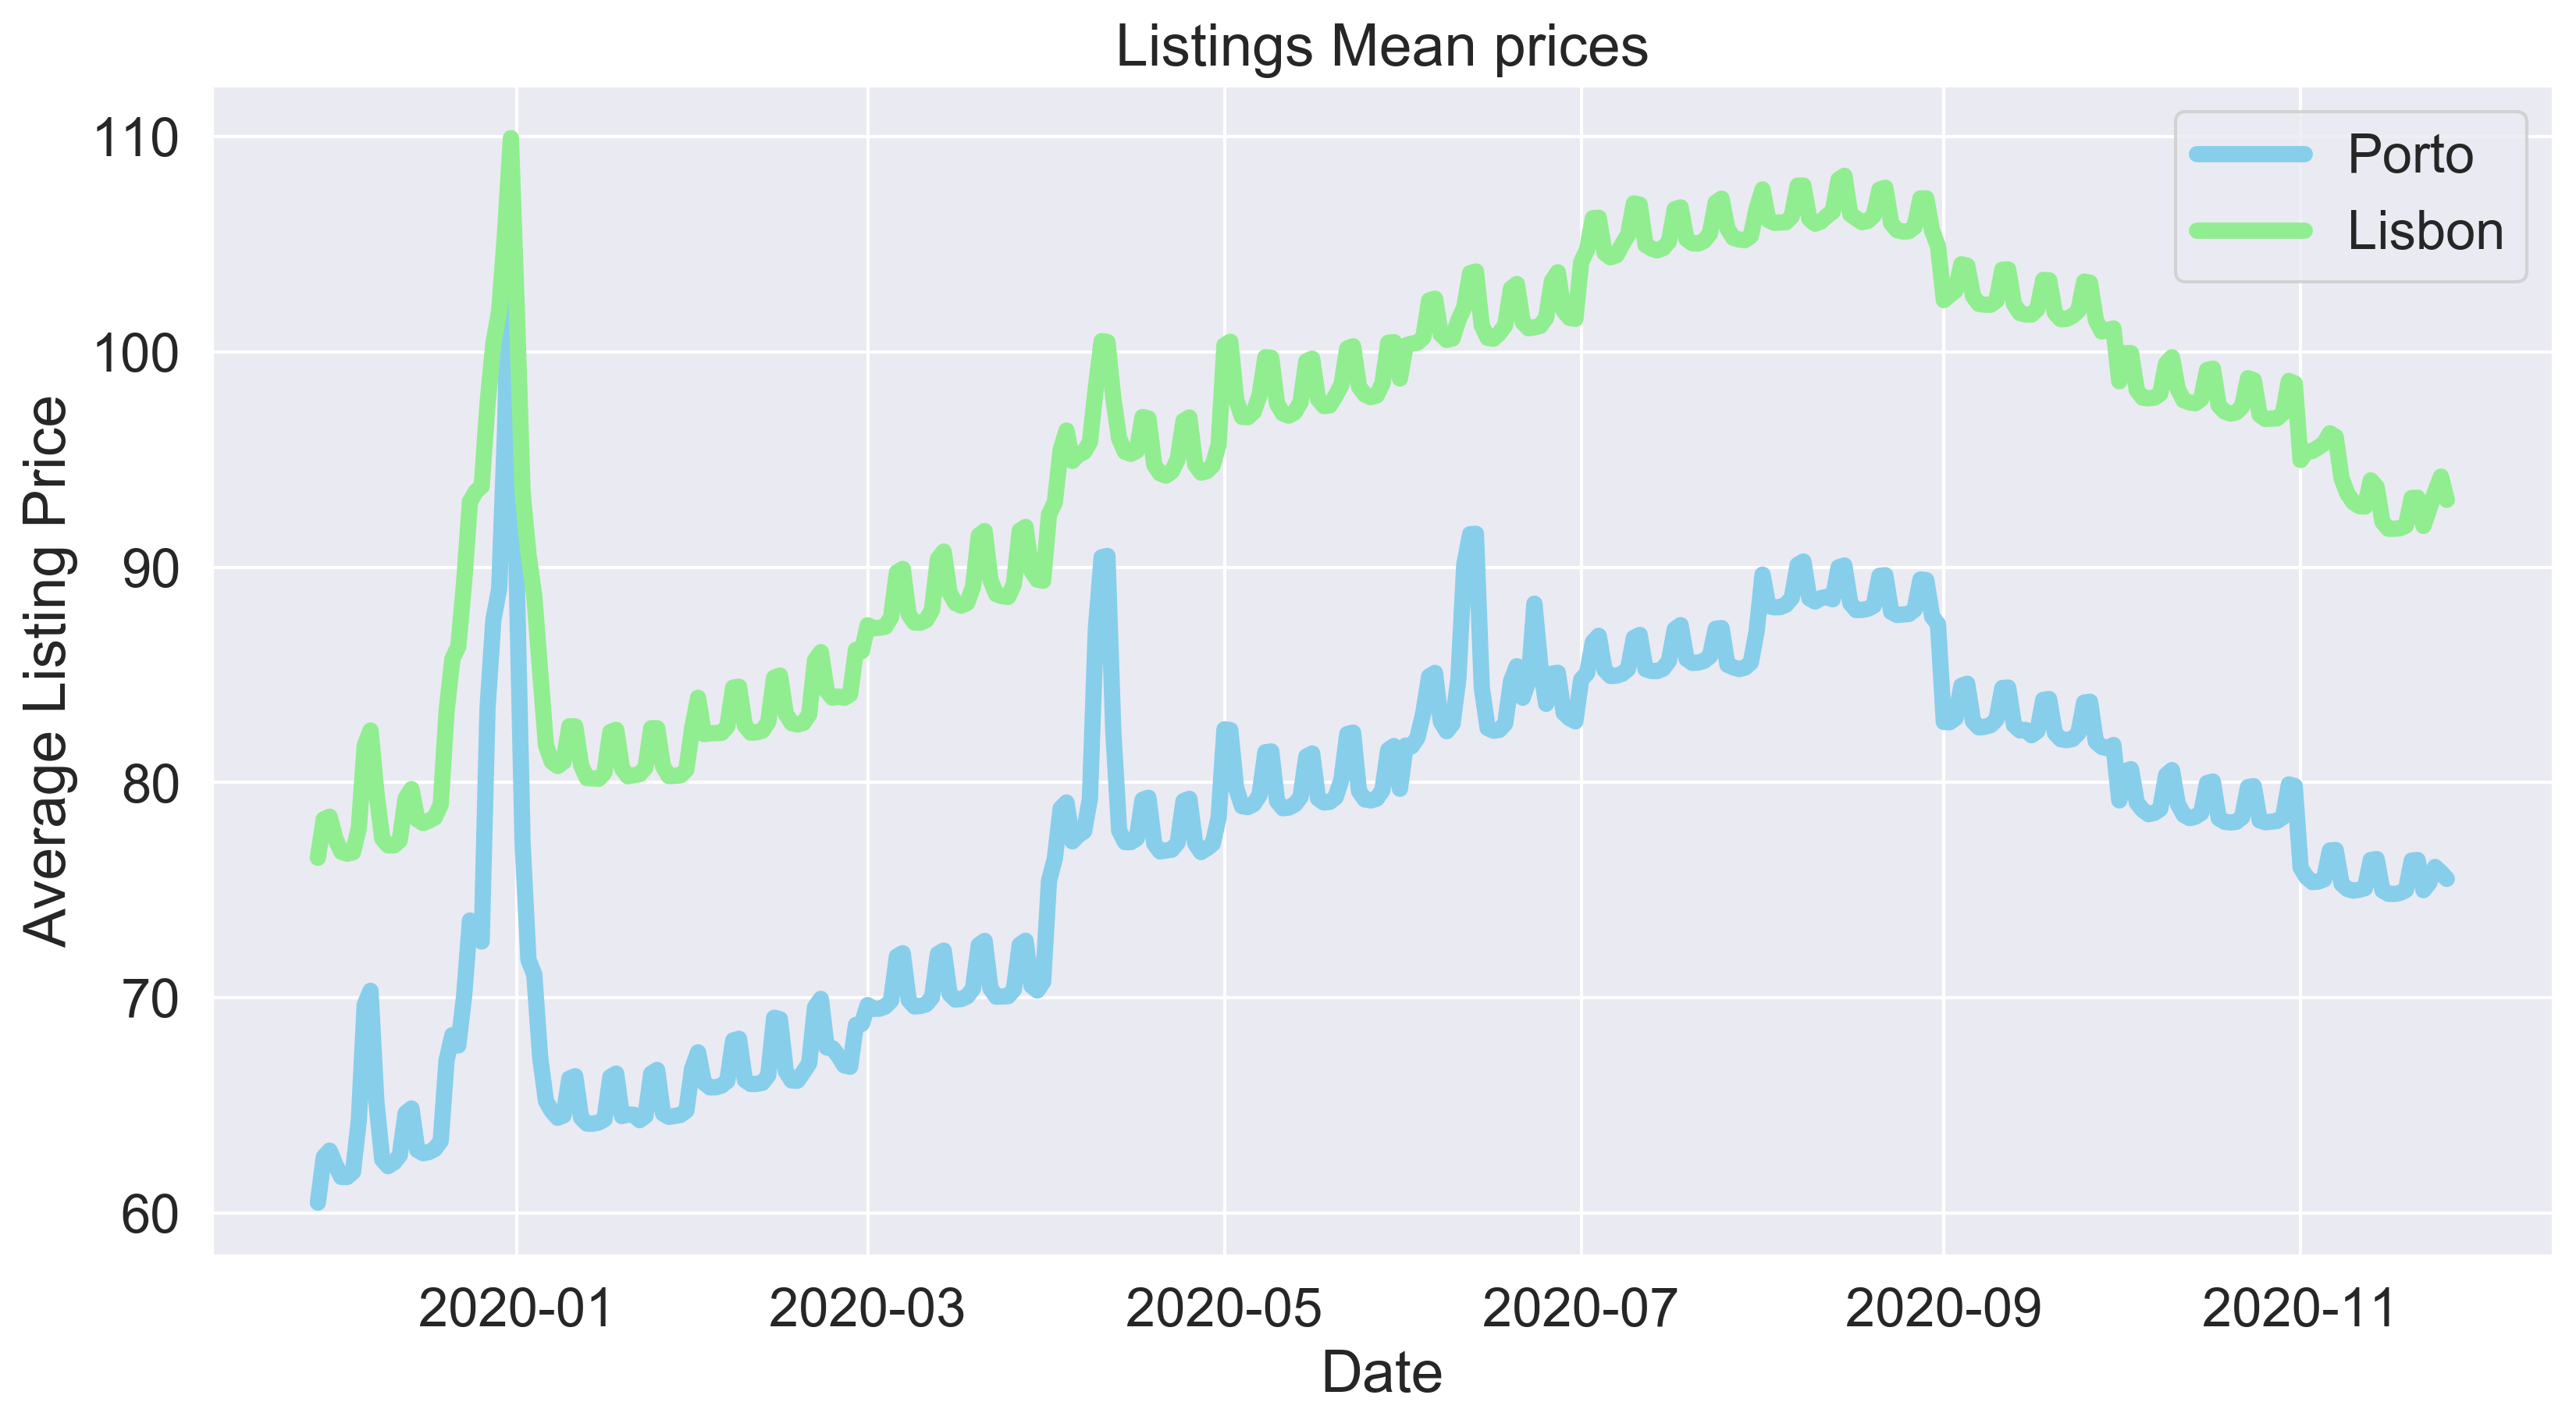

In [96]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])

ax.plot(mean_price_porto['price'], label = 'Porto', color = 'skyblue', linewidth = 5)
ax.plot(mean_price_lisbon['price'], label = 'Lisbon', color = 'lightgreen', linewidth = 5)

ax.set_title('Listings Mean prices')
ax.legend()

ax.set_xlabel('Date')
ax.set_ylabel('Average Listing Price')

There are very clear variations on the prices:
* first peak corresponds to NYE
* second peak probably corresponds to the 25th of April in Portugal
* third peak in porto probably corresponds to Saint John's celebrations/NOS Music festival/F1 Grand Prix

Before the next few steps I want to do some feature engineering to improve the status of some of categorical attributes

## Which are the most expensive neighbourhoods?

In [97]:
porto_grouped = pd.DataFrame(porto_listings_m.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
porto_grouped.reset_index(inplace=True)
lisbon_grouped = pd.DataFrame(lisbon_listings_m.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
lisbon_grouped.reset_index(inplace=True)

Text(0.5, 1.0, '\nMedian Prices by Neighbourhood\n')

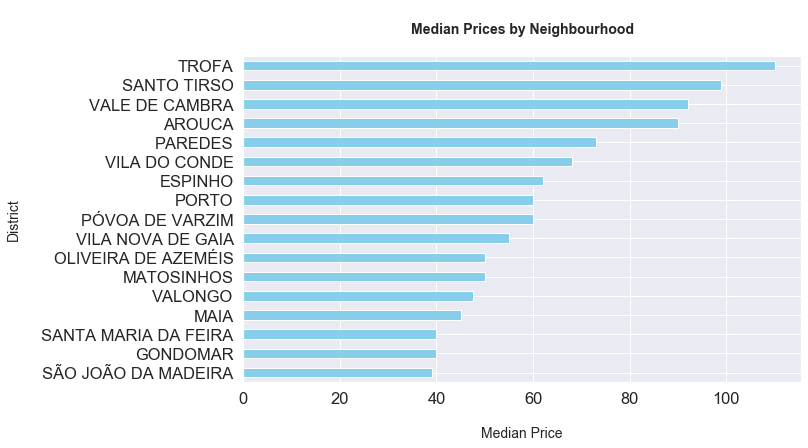

In [98]:
porto_grouped.sort_values(by=['price'], ascending=True).plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                                                          figsize=(10,6), legend=False, color = 'skyblue')

plt.xlabel('\nMedian Price', fontsize=14)
plt.ylabel('District\n', fontsize=14)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

Text(0.5, 1.0, '\nMedian Prices\n')

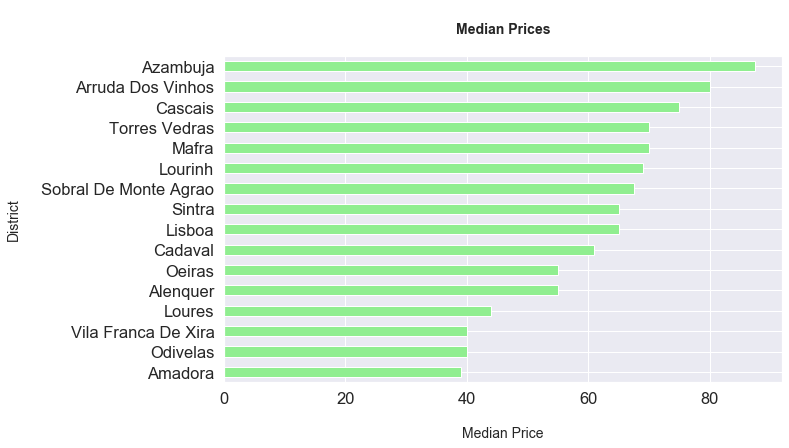

In [99]:
lisbon_grouped.sort_values(by=['price'], ascending=True).plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                                                          figsize=(10,6), legend=False, color = 'lightgreen')

plt.xlabel('\nMedian Price', fontsize=14)
plt.ylabel('District\n', fontsize=14)
plt.title('\nMedian Prices\n', fontsize=14, fontweight='bold')

In [100]:
porto_grouped_2 = pd.DataFrame(porto_listings_m.groupby(['neighbourhood_cleansed'])['price'].agg(np.median))
porto_grouped_2.reset_index(inplace=True)
lisbon_grouped_2 = pd.DataFrame(lisbon_listings_m.groupby(['neighbourhood_cleansed'])['price'].agg(np.median))
lisbon_grouped_2.reset_index(inplace=True)

In [101]:
#sorting based on reviews
porto_grouped_2.sort_values(by = 'price', ascending = False, axis = 0, inplace = True)
lisbon_grouped_2.sort_values(by = 'price', ascending = False, axis = 0, inplace = True)

#and setting up a minimal df for the top listings
porto_top40 = porto_grouped_2.head(40)
lisbon_top40 = lisbon_grouped_2.head(40)

Text(0.5, 1.0, '\nPorto: Median Prices by Neighbourhood\n')

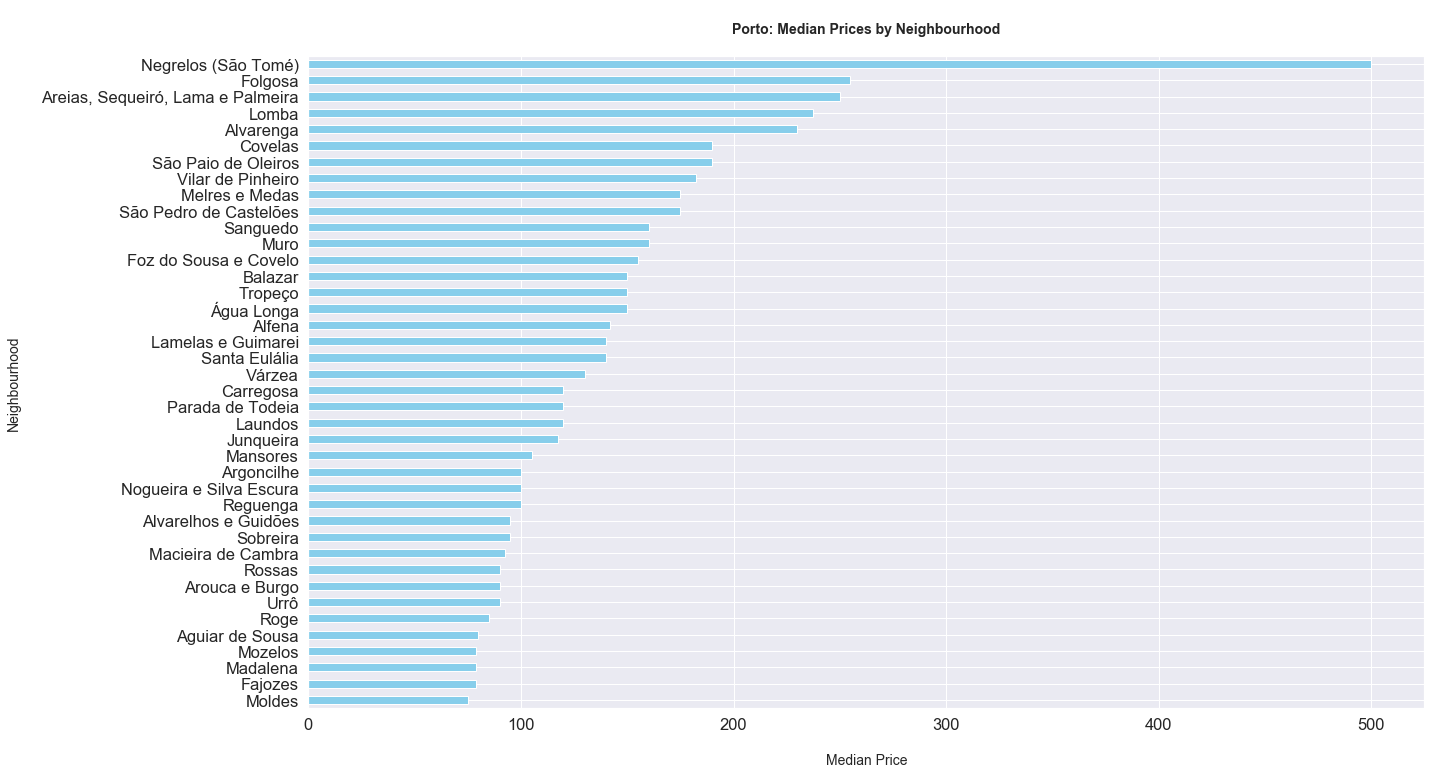

In [102]:
porto_top40.sort_values(by=['price'], ascending=True).plot(kind='barh', x='neighbourhood_cleansed', y='price', 
                                                          figsize=(20,12), legend=False, color = 'skyblue')

plt.xlabel('\nMedian Price', fontsize=14)
plt.ylabel('Neighbourhood\n', fontsize=14)
plt.title('\nPorto: Median Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

Text(0.5, 1.0, '\nLisbon: Median Prices by Neighbourhood\n')

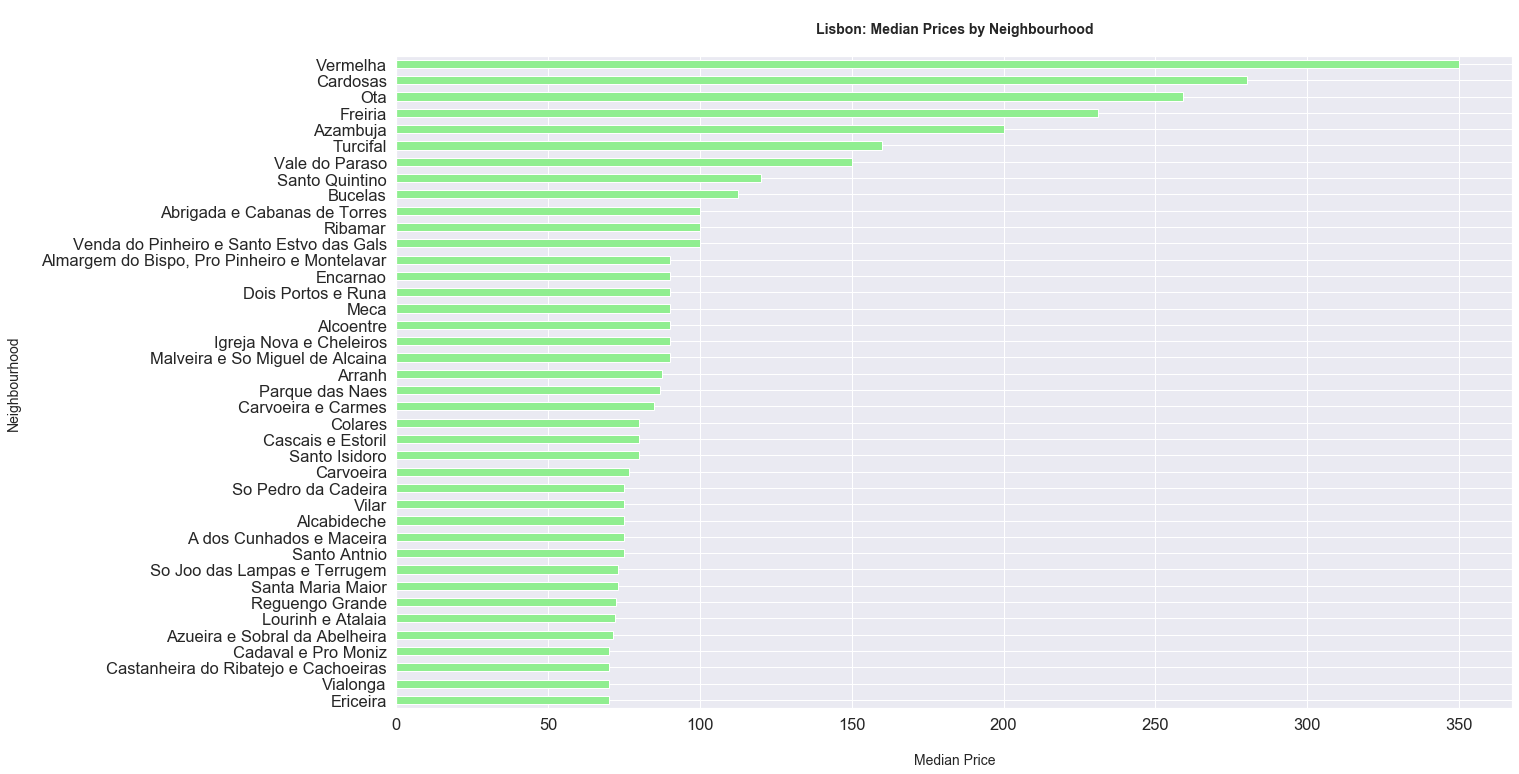

In [103]:
lisbon_top40.sort_values(by=['price'], ascending=True).plot(kind='barh', x='neighbourhood_cleansed', y='price', 
                                                          figsize=(20,12), legend=False, color = 'lightgreen')

plt.xlabel('\nMedian Price', fontsize=14)
plt.ylabel('Neighbourhood\n', fontsize=14)
plt.title('\nLisbon: Median Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

## What is the superhost distribution?

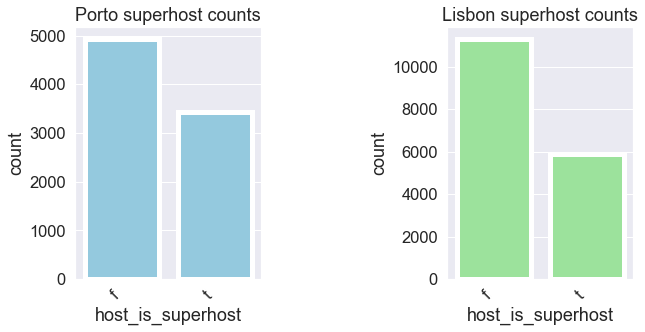

In [104]:
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1 = sns.countplot(x = 'host_is_superhost', data = porto_listings_m,
                    order = porto_listings_m.host_is_superhost.value_counts().sort_values(ascending=False).index, ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto superhost counts')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, horizontalalignment='right')


ax2 = sns.countplot(x = 'host_is_superhost', data = lisbon_listings_m,
                    order = lisbon_listings_m.host_is_superhost.value_counts().sort_values(ascending=False).index, ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon superhost counts')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, horizontalalignment='right')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

In [105]:
porto_listings_plus['host_is_superhost'].value_counts()

f    5405
t    3610
Name: host_is_superhost, dtype: int64

In [106]:
lisbon_listings_plus['host_is_superhost'].value_counts()

f    12712
t     6296
Name: host_is_superhost, dtype: int64

### Feature Engineering

In [107]:
porto_listings_m.property_type.value_counts()

Apartment                 6059
House                      994
Loft                       329
Serviced apartment         218
Townhouse                  145
Condominium                119
Guesthouse                 114
Guest suite                 57
Villa                       54
Hostel                      42
Boutique hotel              37
Boat                        34
Bed and breakfast           31
Cottage                     31
Tiny house                  30
Camper/RV                   18
Bungalow                     8
Other                        7
Chalet                       6
Earth house                  6
Hotel                        5
Hut                          4
Cabin                        2
Tent                         2
Farm stay                    2
Casa particular (Cuba)       2
Nature lodge                 2
Barn                         1
In-law                       1
Yurt                         1
Name: property_type, dtype: int64

In [132]:
def enc_and_eng(df, df_type):
    '''
    Takes in a dataframe and the string corresponding to the df_type and does feature encoding
    Args: a dataframe and the name of the dataframe
    Returns: df with encoded features
    '''
    if df_type == 'listings':
        
        #dealing with the amenities column, just turn them into a count of available amenities
        df['amenities'] = df['amenities'].str.replace('"', '')
        df['amenities_count'] = df.amenities.str.count(',').add(1)
        
        '''
        #dealing with property type
        df['property_type'] = df['property_type'].replace({'Townhouse': 'House', 'Serviced apartment': 'Apartment', 'Loft': 'Apartment',
                                                           'Bungalow': 'House', 'Cottage': 'House', 'Villa': 'House', 'Tiny house': 'House',
                                                           'Earth house': 'House', 'Chalet': 'House'}, inplace=True)
    
        df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
        '''
    
        
        #creating a list of the categorical features I want to get dummies for
        cat_features = ['neighbourhood_cleansed']
        
        #getting dummies
        df = pd.get_dummies(df, columns = cat_features, prefix = cat_features, drop_first = True)
        
        #creating a dictionary for the replacements in room types
        room_types = {'Entire home/apt' : 1, 'Private room' : 2, 'Hotel room' : 3, 'Shared room' : 4}
        df['room_type'] = df['room_type'].map(room_types)
        
        
        #creating dictionary to replace host_response_time
        resp_time = {'a few days or more' : 1, 'within a day' : 2, 'within a few hours' : 3, 'within an hour' : 4}
        df['host_response_time'] = df['host_response_time'].map(resp_time) 
        
        #creating a column corresponding to the time in operation
        df['time_in_operation'] = (df['last_review'] - df['host_since']).dt.days
        
        #creating feature for time until first review after first posting the listing
        df['time_2_first_review'] = (df['first_review'] - df['host_since']).dt.days
        
        #dealing with the cancelation policies column
        canc_types = {'flexible' : 1, 'moderate' : 2, 'strict' : 3, 'strict_14_with_grace_period' : 3,
                      'super_strict_30' : 4, 'super_strict_60' : 5}
        df['cancellation_policy'] = df['cancellation_policy'].map(canc_types)
        
        #handling host location
        df['host_location'] =  df['host_location'].str.lower()
        df['host_in_pt'] = df['host_location'].str.contains('portugal')
        df['host_in_pt'] = df['host_in_pt'].astype(int)
        
           
        #encoding the boolean columns
        bool_to_bin = {'f' : 0, 't' : 1}
        df['host_is_superhost'] = df['host_is_superhost'].map(bool_to_bin) 
        df['host_has_profile_pic'] = df['host_has_profile_pic'].map(bool_to_bin)
        df['host_identity_verified'] = df['host_identity_verified'].map(bool_to_bin)
        #df['is_location_exact'] = df['is_location_exact'].map(bool_to_bin)
        #df['has_availability'] = df['has_availability'].map(bool_to_bin)
        df['instant_bookable'] = df['instant_bookable'].map(bool_to_bin)
        df['require_guest_profile_picture'] = df['require_guest_profile_picture'].map(bool_to_bin)
        df['require_guest_phone_verification'] = df['require_guest_phone_verification'].map(bool_to_bin)
        
        #creating a feature corresponding to the price per guest
        df['price_per_guest'] = (df['price']/df['accommodates'])

        
        df.drop(['amenities', 'host_name', 'host_location', 
                 'host_since', 'first_review', 'last_review', 
                 'property_type', 'is_location_exact', 'has_availability'], axis = 1, inplace = True)

        
    if df_type == 'calendar':
        #replacing the t and f in the available column with booleans
        available_type = {'f' : 0, 't' : 1}
        df['availability'] = df['available'].map(available_type)
        
    return df

In [133]:
porto_listings_c = enc_and_eng(porto_listings_m, 'listings')
lisbon_listings_c = enc_and_eng(lisbon_listings_m, 'listings')
porto_calendar_c = enc_and_eng(porto_calendar_m, 'calendar')
lisbon_calendar_c = enc_and_eng(lisbon_calendar_m, 'calendar')

In [134]:
porto_listings_c.head()

,id,space,transit,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available,amenities_count,neighbourhood_cleansed_Agrela,neighbourhood_cleansed_Aguiar de Sousa,neighbourhood_cleansed_Aguçadoura e Navais,"neighbourhood_cleansed_Aldoar, Foz do Douro e Nevogilde",neighbourhood_cleansed_Alfena,neighbourhood_cleansed_Alvarelhos e Guidões,neighbourhood_cleansed_Alvarenga,neighbourhood_cleansed_Anta e Guetim,neighbourhood_cleansed_Arcozelo,"neighbourhood_cleansed_Areias, Sequeiró, Lama e Palmeira",...,neighbourhood_cleansed_Ossela,neighbourhood_cleansed_Parada de Todeia,neighbourhood_cleansed_Paranhos,neighbourhood_cleansed_Paredes,neighbourhood_cleansed_Pedroso e Seixezelo,neighbourhood_cleansed_Pedrouços,"neighbourhood_cleansed_Perafita, Lavra e Santa Cruz do Bispo","neighbourhood_cleansed_Pinheiro da Bemposta, Travanca e Palmaz","neighbourhood_cleansed_Póvoa de Varzim, Beiriz e Argivai",neighbourhood_cleansed_Ramalde,neighbourhood_cleansed_Rates,neighbourhood_cleansed_Rebordosa,neighbourhood_cleansed_Reguenga,neighbourhood_cleansed_Retorta e Tougues,neighbourhood_cleansed_Rio Mau e Arcos,neighbourhood_cleansed_Rio Tinto,neighbourhood_cleansed_Roge,neighbourhood_cleansed_Romariz,neighbourhood_cleansed_Rossas,"neighbourhood_cleansed_Sandim, Olival, Lever e Crestuma",neighbourhood_cleansed_Sanguedo,neighbourhood_cleansed_Santa Eulália,"neighbourhood_cleansed_Santa Maria da Feira, Travanca, Sanfins e Espargo",neighbourhood_cleansed_Santa Marinha e São Pedro da Afurada,neighbourhood_cleansed_Serzedo e Perosinho,neighbourhood_cleansed_Silvalde,neighbourhood_cleansed_Sobreira,"neighbourhood_cleansed_St. Tirso, Couto (S. Cristina e S. Miguel) e Burgães",neighbourhood_cleansed_São Félix da Marinha,neighbourhood_cleansed_São João da Madeira,neighbourhood_cleansed_São João de Ver,neighbourhood_cleansed_São Mamede de Infesta e Senhora da Hora,neighbourhood_cleansed_São Paio de Oleiros,neighbourhood_cleansed_São Pedro Fins,neighbourhood_cleansed_São Pedro de Castelões,neighbourhood_cleansed_Tropeço,neighbourhood_cleansed_Urrô,neighbourhood_cleansed_Valongo,neighbourhood_cleansed_Vila Chã,neighbourhood_cleansed_Vila Nova da Telha,neighbourhood_cleansed_Vila de Cucujães,neighbourhood_cleansed_Vila do Conde,neighbourhood_cleansed_Vilar de Andorinho,neighbourhood_cleansed_Vilar de Pinheiro,neighbourhood_cleansed_Vilar e Mosteiró,neighbourhood_cleansed_Várzea,neighbourhood_cleansed_Água Longa,neighbourhood_cleansed_Águas Santas,neighbourhood_cleansed_Árvore,time_in_operation,time_2_first_review,host_in_pt,price_per_guest
4513,23994022,1,1,45139298,4,100.0,1,2.0,1,1,MAIA,41.22855,-8.61190,1,6,2.0,3.0,3.0,65.0,1,1,0.0,2,27,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,3,0,0,0.48,1,1,1,1,7.397260,20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1414,1399,0,10.833333
6294,30883589,1,1,153745488,4,100.0,1,36.0,1,0,PORTO,41.15303,-8.60037,1,2,1.0,1.0,1.0,69.0,1,1,0.0,2,318,4,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2,0,0,0.41,1,1,1,1,87.123288,51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,684,491,1,34.500000
8110,38148258,1,1,288327506,4,100.0,0,0.0,1,0,PORTO,41.15252,-8.61306,1,6,1.5,2.0,4.0,80.0,1,1,15.0,2,355,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2,0,0,0.41,1,1,1,1,97.260274,14,0

### How does the availability of the properties look like throughout the dates present in the dataset?

Text(0, 0.5, 'Listings counts')

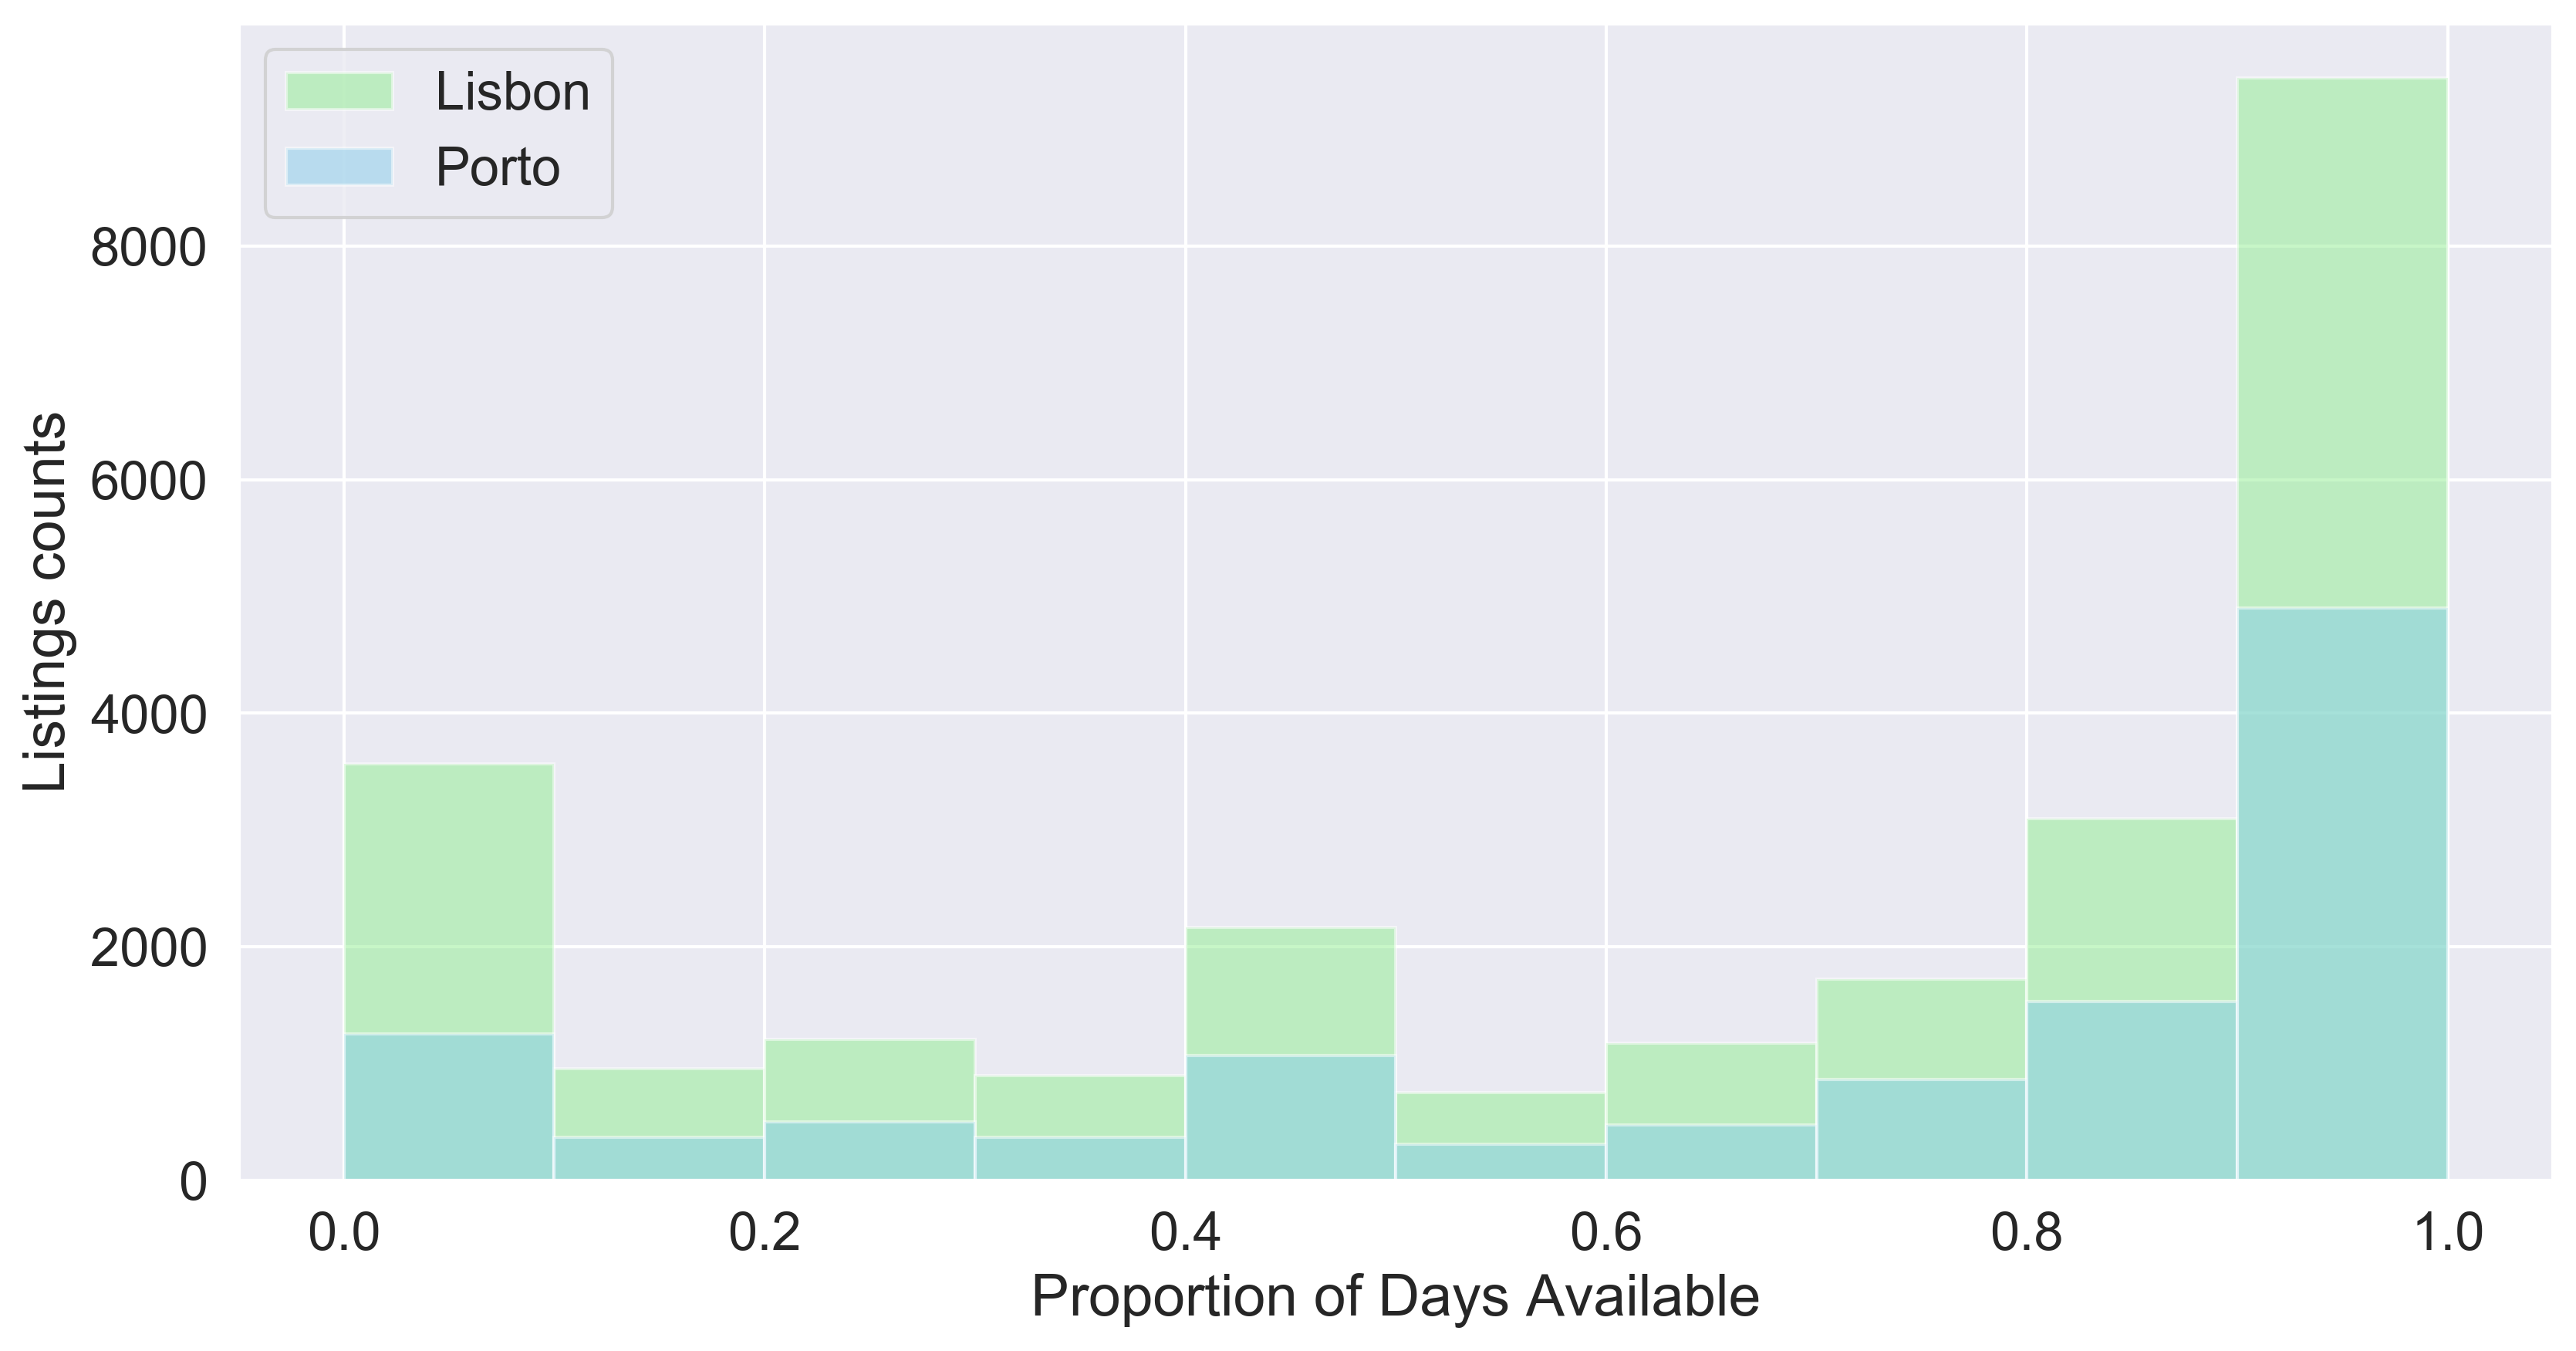

In [135]:
fig = plt.figure(figsize=(10,5),dpi=300)

ax = fig.add_axes([0,0,1,1])
ax.hist(lisbon_calendar_c.groupby('id').mean()['availability'],bins=10,alpha=0.5, label='Lisbon', color = 'lightgreen')
ax.hist(porto_calendar_c.groupby('id').mean()['availability'],bins=10,alpha=0.5, label='Porto', color = 'skyblue')
ax.legend()
ax.set_xlabel('Proportion of Days Available')
ax.set_ylabel('Listings counts')


In [136]:
print('______________' + 'Porto availability at any given time %' + '______________')
print('______________________', str(porto_calendar_c['availability'].mean()*100), '_______________________')
print('______________' + 'Lisbon availability at any given time %' + '_____________')
print('______________________', str(lisbon_calendar_c['availability'].mean()*100), '______________________')

______________Porto availability at any given time %______________
______________________ 68.5015869572394 _______________________
______________Lisbon availability at any given time %_____________
______________________ 64.07549542636843 ______________________


It looks like there is a group of listings that spend most of their time on airbnb completely available. Curious if in the end we will discover why.
Other than that these are good news for travelers, you have a high chance to always find a place to stay.

## Princing is one of the factors of focus on this exploration, now that I have a feature that normalizes the price of the properties based on the number of guests that they accommodate are their outliers/luxury market?

How does the price per guest relate to the number of reviews a listing gets?

In [137]:
price_v_review_porto = porto_listings_c[['reviews_per_month', 'price_per_guest']].sort_values(by = 'price_per_guest')
price_v_review_lisbon = lisbon_listings_c[['reviews_per_month', 'price_per_guest']].sort_values(by = 'price_per_guest')

(0, 300)

<Figure size 1440x1008 with 0 Axes>

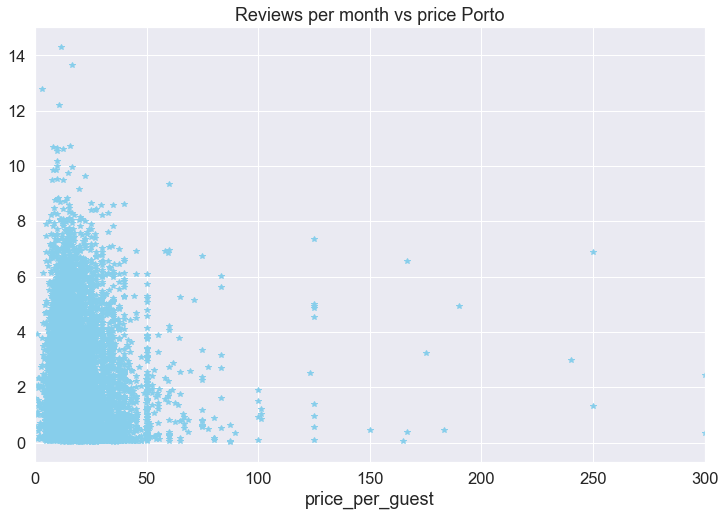

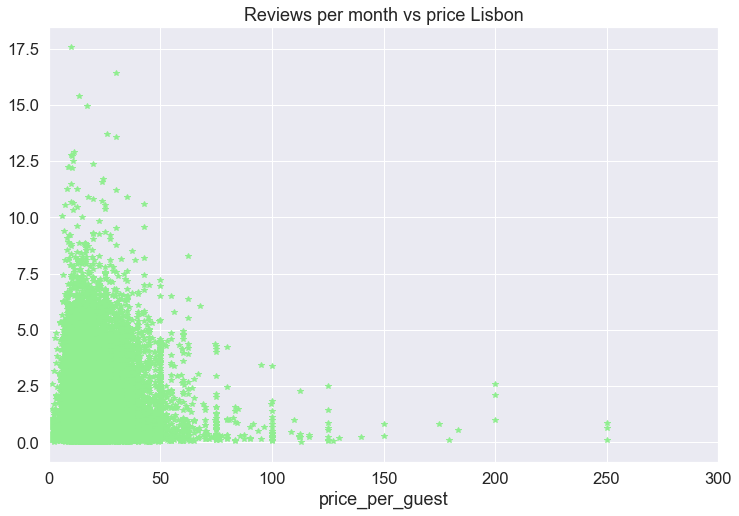

In [138]:
fig = plt.figure(figsize = (20,14))

price_v_review_porto.plot(x = 'price_per_guest', y = 'reviews_per_month',style = '*', figsize =(12,8), legend = False, color = 'skyblue', title = 'Reviews per month vs price Porto')

price_v_review_lisbon.plot(x = 'price_per_guest', y = 'reviews_per_month',style = '*', figsize =(12,8), legend = False, color = 'lightgreen', title = 'Reviews per month vs price Lisbon')
plt.xlim(0, 300)

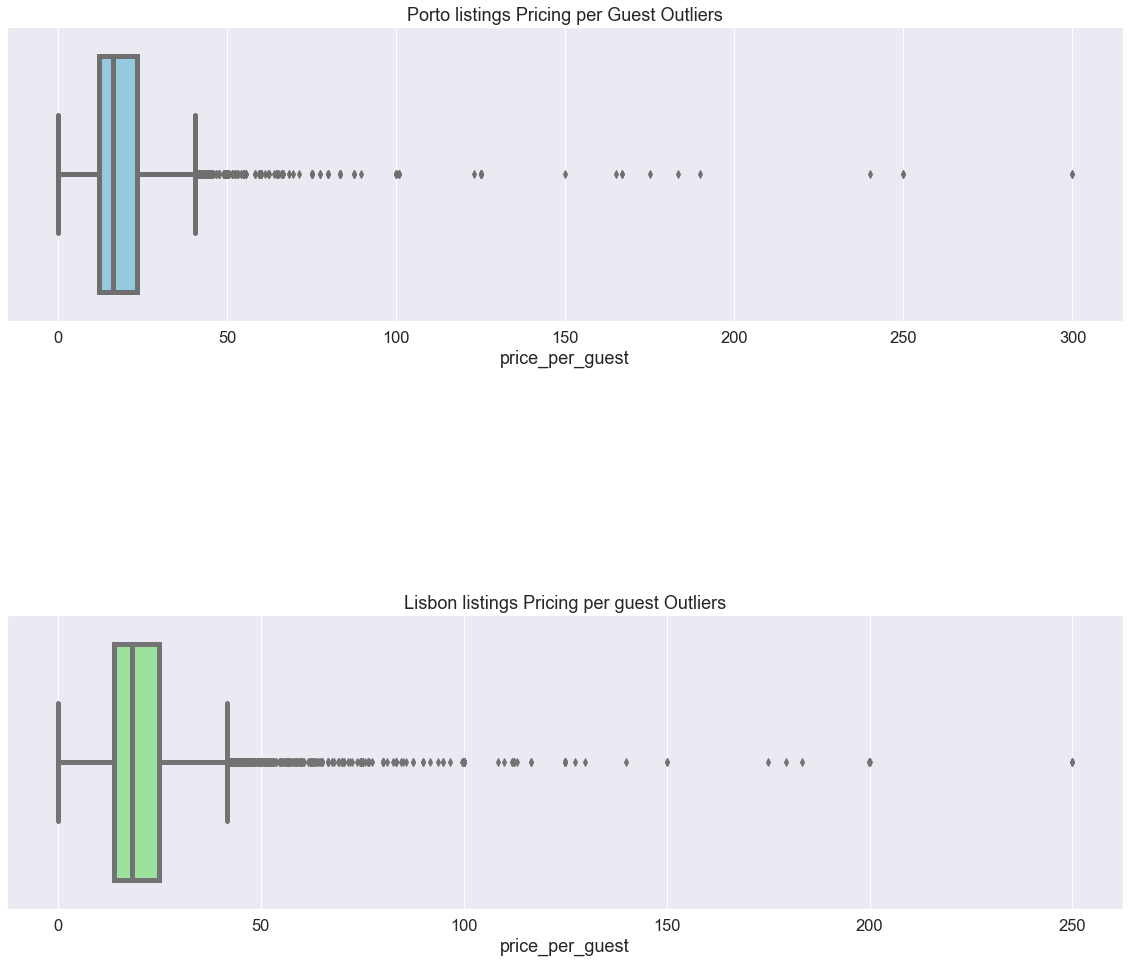

In [139]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1 = sns.boxplot(x = porto_listings_c['price_per_guest'], ax = ax1, color = 'skyblue', linewidth = 5)
ax1.set_title('Porto listings Pricing per Guest Outliers')

ax2 = sns.boxplot(x = lisbon_listings_c['price_per_guest'], ax = ax2, color = 'lightgreen', linewidth = 5)
ax2.set_title('Lisbon listings Pricing per guest Outliers')

fig.subplots_adjust(top = 1, wspace = 1, hspace = 1)

In [140]:
porto_listings_c['price_per_guest'].describe()

count    8361.000000
mean       19.286839
std        13.484674
min         0.000000
25%        12.000000
50%        16.250000
75%        23.500000
max       300.000000
Name: price_per_guest, dtype: float64

In [141]:
lisbon_listings_c['price_per_guest'].describe()

count    17203.000000
mean        21.221173
std         12.549219
min          0.000000
25%         13.750000
50%         18.333333
75%         25.000000
max        250.000000
Name: price_per_guest, dtype: float64

In [142]:
porto_grouped = pd.DataFrame(porto_listings_c.groupby(['neighbourhood_group_cleansed'])['price_per_guest'].agg(np.median))
porto_grouped.reset_index(inplace=True)
lisbon_grouped = pd.DataFrame(lisbon_listings_c.groupby(['neighbourhood_group_cleansed'])['price_per_guest'].agg(np.median))
lisbon_grouped.reset_index(inplace=True)

Text(0.5, 1.0, '\nMedian Prices per guest by Neighbourhood\n')

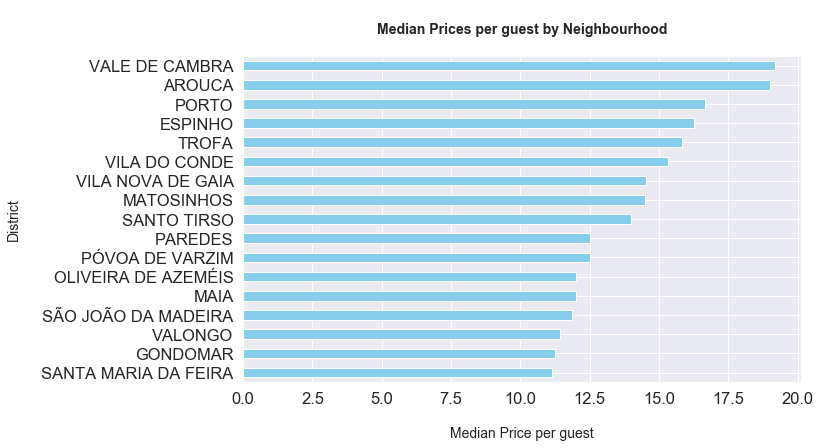

In [145]:
porto_grouped.sort_values(by=['price_per_guest'], ascending=True).plot(kind='barh', x='neighbourhood_group_cleansed', y='price_per_guest', 
                                                          figsize=(10,6), legend=False, color = 'skyblue')

plt.xlabel('\nMedian Price per guest', fontsize=14)
plt.ylabel('District\n', fontsize=14)
plt.title('\nMedian Prices per guest by Neighbourhood\n', fontsize=14, fontweight='bold')

Text(0.5, 1.0, '\nMedian Prices per guest by Neighbourhood\n')

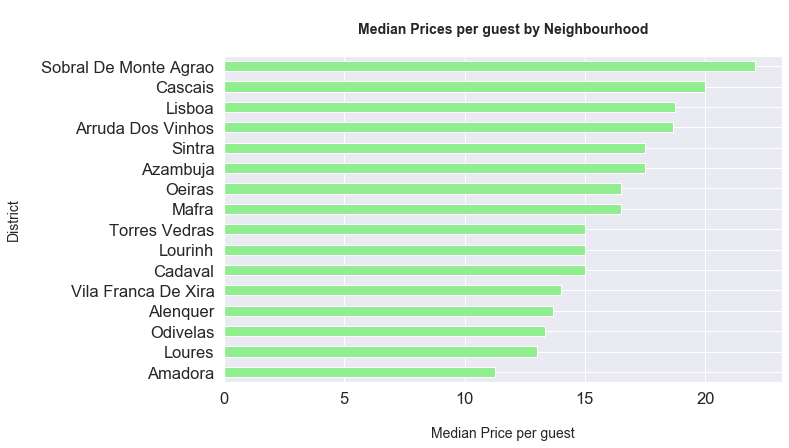

In [147]:
lisbon_grouped.sort_values(by=['price_per_guest'], ascending=True).plot(kind='barh', x='neighbourhood_group_cleansed', y='price_per_guest', 
                                                          figsize=(10,6), legend=False, color = 'lightgreen')

plt.xlabel('\nMedian Price per guest', fontsize=14)
plt.ylabel('District\n', fontsize=14)
plt.title('\nMedian Prices per guest by Neighbourhood\n', fontsize=14, fontweight='bold')

Since there are some listings with a value of 0 and many that have a max value much higher than the mean I will filter some of these values out

In [122]:
porto_listings_c.drop(porto_listings_c[(porto_listings_c.price_per_guest > 100) | (porto_listings_c.price_per_guest < 5)]
                     .index, axis = 0, inplace = True)

porto_listings_c['price_per_guest'].describe()

count    8252.000000
mean       19.013225
std        10.395002
min         5.000000
25%        12.250000
50%        16.250000
75%        23.500000
max       100.000000
Name: price_per_guest, dtype: float64

In [123]:
lisbon_listings_c.drop(lisbon_listings_c[(lisbon_listings_c.price_per_guest > 100) | (lisbon_listings_c.price_per_guest < 5)]
                     .index, axis = 0, inplace = True)

lisbon_listings_c['price_per_guest'].describe()

count    17034.000000
mean        21.125239
std         11.068824
min          5.000000
25%         13.750000
50%         18.500000
75%         25.000000
max        100.000000
Name: price_per_guest, dtype: float64

Now that I am done with vis to determine what the cuttof is I can drop the engineered column

In [124]:
porto_listings_c.drop(['price_per_guest'], axis = 1, inplace = True)
lisbon_listings_c.drop(['price_per_guest'], axis = 1, inplace = True)

### Feature Selection

Text(0.5, 1, 'Correlation Matrix Porto Listings')

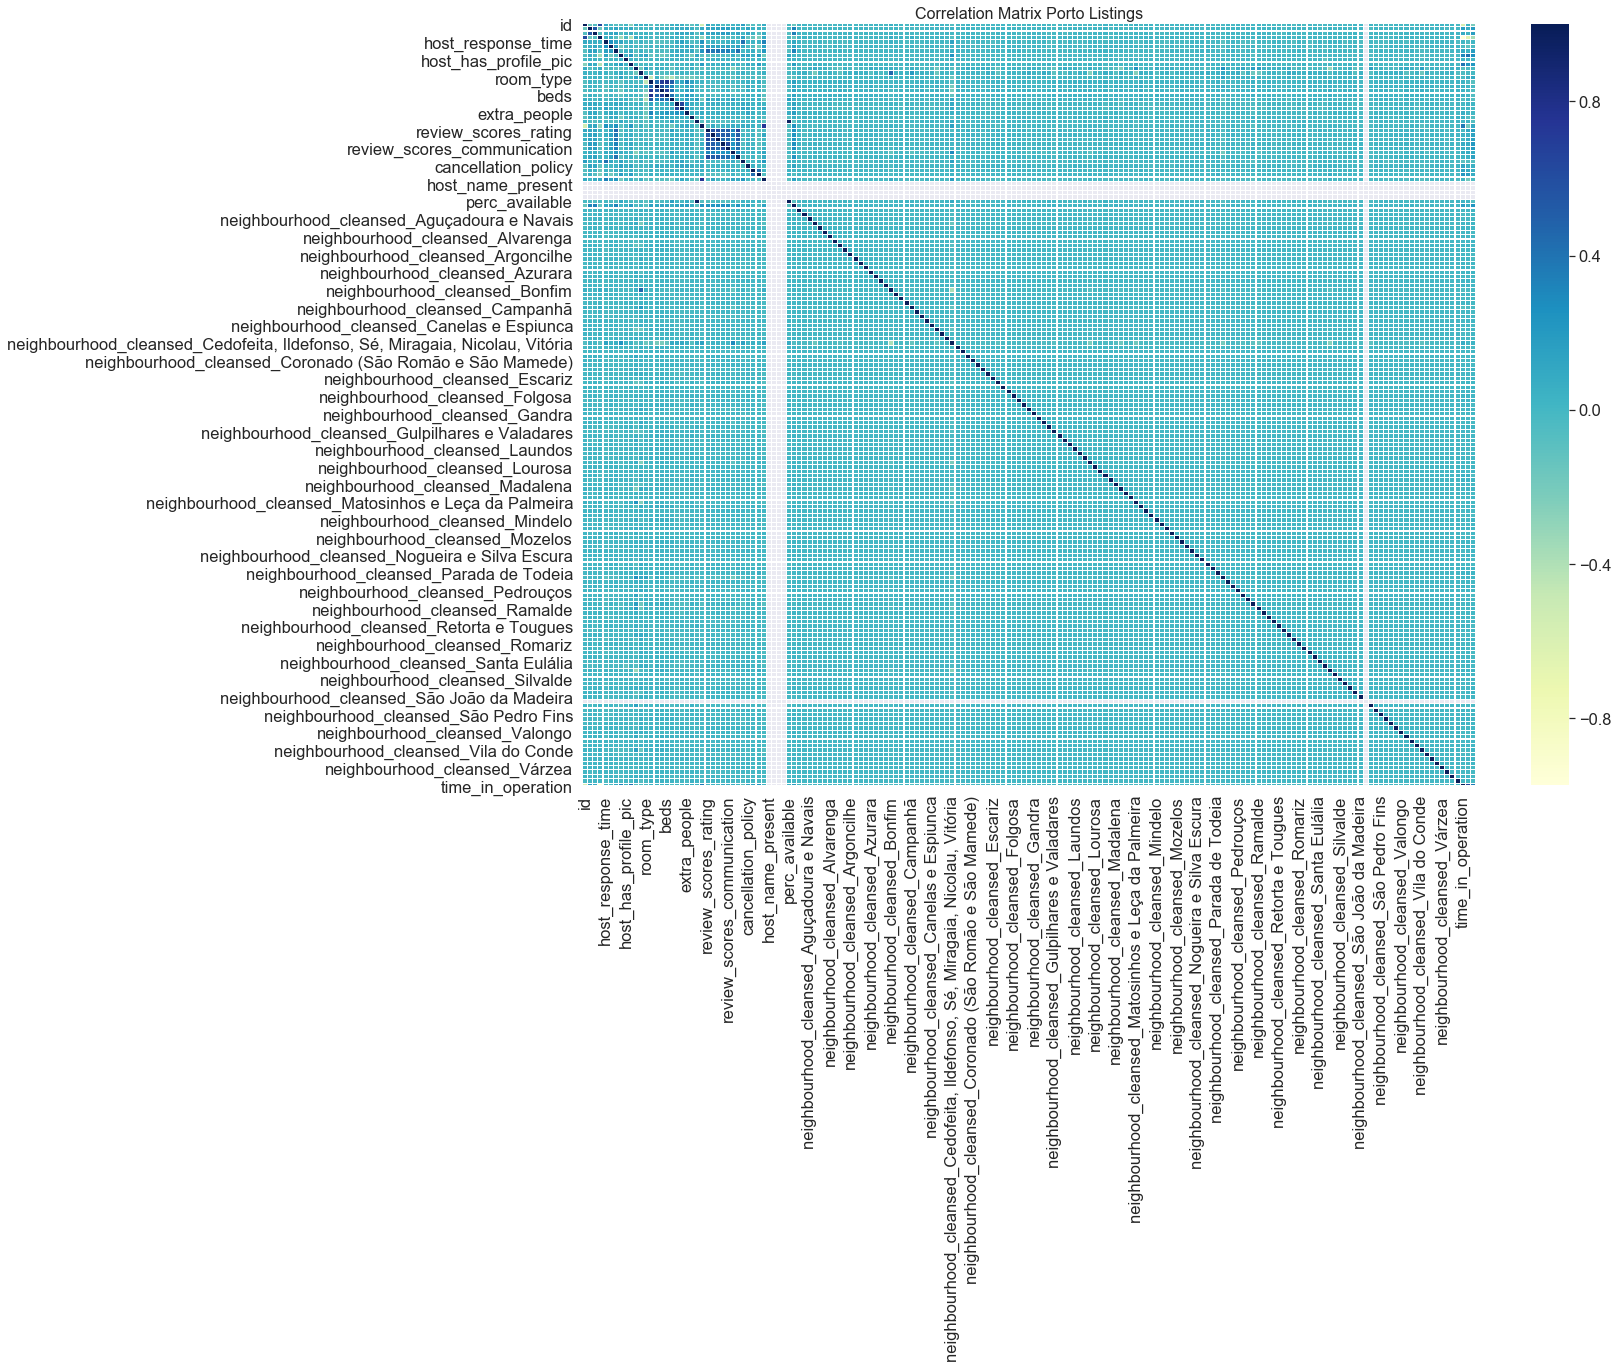

In [125]:
fig = plt.figure(figsize = (20,14))
ax1 = fig.add_subplot(111)

corr_matrix_porto = porto_listings_c.corr(method = 'spearman')
ax1 = sns.heatmap(corr_matrix_porto, cmap="YlGnBu", linewidths=0.1, ax = ax1)
ax1.set_title('Correlation Matrix Porto Listings', fontsize=16)

## Checking for highly correlated features

In [126]:
def corr_2_drop(df):
    '''
    Takes in a dataframe and returns a list of columns to drop based on a correlation value over 0.95
    '''
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    return to_drop

In [127]:
to_drop_porto = corr_2_drop(porto_listings_c)
to_drop_porto

[]

In [128]:
to_drop_lisbon = corr_2_drop(lisbon_listings_c)
to_drop_lisbon

[]

Unfortunately for now there are simply too many features to be able to properly check correlations. I will address feature selection on a separate notebook.

In [129]:
#saving the data files for the listings after feature engineering for model testing
porto_listings_c.to_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\porto_listings.csv")
lisbon_listings_c.to_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\lisbon_listings.csv")

In [130]:
porto_listings_c.head()

,id,space,transit,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_name_present,last_review_present,first_review_present,host_since_present,perc_available,amenities_count,neighbourhood_cleansed_Agrela,neighbourhood_cleansed_Aguiar de Sousa,neighbourhood_cleansed_Aguçadoura e Navais,"neighbourhood_cleansed_Aldoar, Foz do Douro e Nevogilde",neighbourhood_cleansed_Alfena,neighbourhood_cleansed_Alvarelhos e Guidões,neighbourhood_cleansed_Alvarenga,neighbourhood_cleansed_Anta e Guetim,neighbourhood_cleansed_Arcozelo,"neighbourhood_cleansed_Areias, Sequeiró, Lama e Palmeira",neighbourhood_cleansed_Argoncilhe,...,neighbourhood_cleansed_Oliveira do Douro,neighbourhood_cleansed_Ossela,neighbourhood_cleansed_Parada de Todeia,neighbourhood_cleansed_Paranhos,neighbourhood_cleansed_Paredes,neighbourhood_cleansed_Pedroso e Seixezelo,neighbourhood_cleansed_Pedrouços,"neighbourhood_cleansed_Perafita, Lavra e Santa Cruz do Bispo","neighbourhood_cleansed_Pinheiro da Bemposta, Travanca e Palmaz","neighbourhood_cleansed_Póvoa de Varzim, Beiriz e Argivai",neighbourhood_cleansed_Ramalde,neighbourhood_cleansed_Rates,neighbourhood_cleansed_Rebordosa,neighbourhood_cleansed_Reguenga,neighbourhood_cleansed_Retorta e Tougues,neighbourhood_cleansed_Rio Mau e Arcos,neighbourhood_cleansed_Rio Tinto,neighbourhood_cleansed_Roge,neighbourhood_cleansed_Romariz,neighbourhood_cleansed_Rossas,"neighbourhood_cleansed_Sandim, Olival, Lever e Crestuma",neighbourhood_cleansed_Sanguedo,neighbourhood_cleansed_Santa Eulália,"neighbourhood_cleansed_Santa Maria da Feira, Travanca, Sanfins e Espargo",neighbourhood_cleansed_Santa Marinha e São Pedro da Afurada,neighbourhood_cleansed_Serzedo e Perosinho,neighbourhood_cleansed_Silvalde,neighbourhood_cleansed_Sobreira,"neighbourhood_cleansed_St. Tirso, Couto (S. Cristina e S. Miguel) e Burgães",neighbourhood_cleansed_São Félix da Marinha,neighbourhood_cleansed_São João da Madeira,neighbourhood_cleansed_São João de Ver,neighbourhood_cleansed_São Mamede de Infesta e Senhora da Hora,neighbourhood_cleansed_São Paio de Oleiros,neighbourhood_cleansed_São Pedro Fins,neighbourhood_cleansed_São Pedro de Castelões,neighbourhood_cleansed_Tropeço,neighbourhood_cleansed_Urrô,neighbourhood_cleansed_Valongo,neighbourhood_cleansed_Vila Chã,neighbourhood_cleansed_Vila Nova da Telha,neighbourhood_cleansed_Vila de Cucujães,neighbourhood_cleansed_Vila do Conde,neighbourhood_cleansed_Vilar de Andorinho,neighbourhood_cleansed_Vilar de Pinheiro,neighbourhood_cleansed_Vilar e Mosteiró,neighbourhood_cleansed_Várzea,neighbourhood_cleansed_Água Longa,neighbourhood_cleansed_Águas Santas,neighbourhood_cleansed_Árvore,time_in_operation,time_2_first_review,host_in_pt
4513,23994022,1,1,45139298,4,100.0,1,2.0,1,1,41.22855,-8.61190,1,6,2.0,3.0,3.0,65.0,1,1,0.0,2,27,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,3,0,0,0.48,1,1,1,1,7.397260,20,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1414,1399,0
6294,30883589,1,1,153745488,4,100.0,1,36.0,1,0,41.15303,-8.60037,1,2,1.0,1.0,1.0,69.0,1,1,0.0,2,318,4,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2,0,0,0.41,1,1,1,1,87.123288,51,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,684,491,1
8110,38148258,1,1,288327506,4,100.0,0,0.0,1,0,41.15252,-8.61306,1,6,1.5,2.0,4.0,80.0,1,1,15.0,2,355,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2,0,0,0.41,1,1,1,1,97.260274,14,

## Minimal engineering option

In [ ]:
def min_prep(df):
    
    
    #creating a column to keep track of rows with missing values using booleans, missing values will be 0
    df['host_name_present'] = (~df['host_name'].isnull()).astype(int)
    df['transit'] = (~df['transit'].isnull()).astype(int)
    df['space'] = (~df['space'].isnull()).astype(int)


    #fill NaT with a mock date
    df['last_review_present'] = (~df['last_review'].isnull()).astype(int)
    date_replace = pd.to_datetime('2019-12-31')
    df['last_review'] = df['last_review'].replace({pd.NaT : date_replace})

    df['first_review_present'] = (~df['first_review'].isnull()).astype(int)
    date_replace = pd.to_datetime('2019-12-31')
    df['first_review'] = df['first_review'].replace({pd.NaT : date_replace})

    df['host_since_present'] = (~df['host_since'].isnull()).astype(int)
    date_replace = pd.to_datetime('2019-12-31')
    df['host_since'] = df['host_since'].replace({pd.NaT : date_replace})


    #fill the NaNs in remaining columns using sklearn's imputer
    imp = Imputer(missing_values =  np.nan, strategy = 'mean', axis = 0)

    df['reviews_p_month_present'] = (~df['reviews_per_month'].isnull()).astype(int)

    df['security_deposit'] = (~df['security_deposit'].isnull()).astype(int)

    df['reviews_per_month'] = imp.fit_transform(df[['reviews_per_month']]).ravel()

    df['host_response_rate'] = imp.fit_transform(df[['host_response_rate']]).ravel()

    #and for anything else missing I will just drop it
    df.dropna(inplace = True)
    
    #dealing with the amenities column, just turn them into a count of available amenities
    df['amenities'] = df['amenities'].str.replace('"', '')
    df['amenities_count'] = df.amenities.str.count(',').add(1)

    #creating a list of the categorical features I want to get dummies for
    cat_features = ['neighbourhood_cleansed']

    #getting dummies
    df = pd.get_dummies(df, columns = cat_features, prefix = cat_features, drop_first = True)

    #creating a dictionary for the replacements in room types
    room_types = {'Entire home/apt' : 1, 'Private room' : 2, 'Hotel room' : 3, 'Shared room' : 4}
    df['room_type'] = df['room_type'].map(room_types)

    #creating dictionary to replace host_response_time
    resp_time = {'a few days or more' : 1, 'within a day' : 2, 'within a few hours' : 3, 'within an hour' : 4}
    df['host_response_time'] = df['host_response_time'].map(resp_time) 

    #creating a column corresponding to the time in operation
    df['time_in_operation'] = (df['last_review'] - df['host_since']).dt.days

    #creating feature for time until first review after first posting the listing
    df['time_2_first_review'] = (df['first_review'] - df['host_since']).dt.days

    #dealing with the cancelation policies column
    canc_types = {'flexible' : 1, 'moderate' : 2, 'strict' : 3, 'strict_14_with_grace_period' : 3,
                  'super_strict_30' : 4, 'super_strict_60' : 5}
    df['cancellation_policy'] = df['cancellation_policy'].map(canc_types)

    #handling host location
    df['host_location'] =  df['host_location'].str.lower()
    df['host_in_pt'] = df['host_location'].str.contains('portugal')
    df['host_in_pt'] = df['host_in_pt'].astype(int)


    #encoding the boolean columns
    bool_to_bin = {'f' : 0, 't' : 1}
    df['host_is_superhost'] = df['host_is_superhost'].map(bool_to_bin) 
    df['host_has_profile_pic'] = df['host_has_profile_pic'].map(bool_to_bin)
    df['host_identity_verified'] = df['host_identity_verified'].map(bool_to_bin)
    df['is_location_exact'] = df['is_location_exact'].map(bool_to_bin)
    df['has_availability'] = df['has_availability'].map(bool_to_bin)
    df['instant_bookable'] = df['instant_bookable'].map(bool_to_bin)
    #df['is_business_travel_ready'] = df['is_business_travel_ready'].map(bool_to_bin)
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].map(bool_to_bin)
    df['require_guest_phone_verification'] = df['require_guest_phone_verification'].map(bool_to_bin)

    df.drop(['id','amenities', 'host_name', 
             'host_location', 'host_since', 'first_review', 
             'last_review', 'neighbourhood_group_cleansed', 'property_type',
            'latitude', 'longitude', 'host_id'], axis = 1, inplace = True)
    
    
    return df
    

In [ ]:
#Porto related data
porto_listings_2 = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Porto\listings.csv.gz", compression = 'gzip')

#Lisbon related data
lisbon_listings_2 = pd.read_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\Lisbon\listings.csv.gz", compression = 'gzip')


In [ ]:
porto_listings_2.head()

rechecking possible drops

In [ ]:
lisbon_listings_2['require_guest_phone_verification'].value_counts()

In [ ]:
porto_listings_2['require_guest_phone_verification'].value_counts()

In [ ]:
porto_listings_2['is_business_travel_ready'].value_counts()

In [ ]:
lisbon_listings_2['is_business_travel_ready'].value_counts()

In [ ]:
porto_listings_2['is_location_exact'].value_counts()

In [ ]:
column_dropper(porto_listings_2)
column_dropper(lisbon_listings_2)

dtype_fixer(porto_listings_2, 'listings')
dtype_fixer(lisbon_listings_2, 'listings')

In [ ]:
min_prep(porto_listings_2)
min_prep(lisbon_listings_2)

In [ ]:
#saving the data files for the listings after feature engineering for model testing
porto_listings_plus.to_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\porto_listings_min.csv")
lisbon_listings_plus.to_csv(r"C:\Users\sousa\Desktop\github\Airbnb Tale of 2 cities\Data Portugal\lisbon_listings_min.csv")